In [2]:
%pylab inline
import numpy as np
import astropy.table
from astropy.io import fits 
import matplotlib.pylab as pylab
import matplotlib.mlab  as mlab
from scipy.stats import norm
from sklearn.mixture import GMM
from __future__ import division
#from astroML.plotting import hist
#from astroML.plotting import setup_text_plots
# Matplotlib default settings
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 14, 10

Populating the interactive namespace from numpy and matplotlib


# Results from Fake Galaxies Test on Coadded COSMOS Images (ExpModels)

* Only used the **i-band** images from 3 full-visits: **1228, 1230, 1238**.
* ExpModels are from Claire's COSMOS catalog. 
* 6000-8000 models are randomly selected from the full catalog, and are asigned with (RA, DEC) within a slightly larger footprint that encloses the COSMOS field.  
* Overlap of fake galaxies are avoided in these tests (Minimum distance between fake galaxies is 15"). 
* Did not try to avoid the overlap between fake and real galaxies.   
* No "edge-on" ExpModel is used (Minimum ellipticity is 0.4). 
* ExpModels in Claire's catalog with very small (\<0.2 arcsec) and large (> 3.5 arcsec) size are excluded.
* The match radius now is 1.0 pixel; And all matched objects are returned. 

In [3]:
expCat1 = 'coscoadd_exp1_coadd_match.fits' # 6000; Randomly selected 
expCat2 = 'coscoadd_exp3_coadd_match.fits' # 6000; Bright ones (mag < 21.5)
expCat3 = 'coscoadd_exp4_coadd_match.fits' # 8000; Faint ones  (mag > 22.5)
expCat4 = 'coscoadd_exp5_coadd_match.fits' # 6000; Bright ones; Second sample  
expCat5 = 'coscoadd_exp6_coadd_match.fits' # 8000; Faint ones; Second sample 

In [4]:
expRes1 = astropy.table.Table().read(expCat1, format='fits')
expRes2 = astropy.table.Table().read(expCat2, format='fits')
expRes3 = astropy.table.Table().read(expCat3, format='fits')
expRes4 = astropy.table.Table().read(expCat4, format='fits')
expRes5 = astropy.table.Table().read(expCat5, format='fits')

In [5]:
# Correct the input effective radius 
expRes1['reff'] /= (np.sqrt(expRes1['b_a']) * expRes1['pixelScale'])
expRes2['reff'] /= (np.sqrt(expRes2['b_a']) * expRes2['pixelScale'])
expRes3['reff'] /= (np.sqrt(expRes3['b_a']) * expRes3['pixelScale'])
expRes4['reff'] /= (np.sqrt(expRes4['b_a']) * expRes4['pixelScale'])
expRes5['reff'] /= (np.sqrt(expRes5['b_a']) * expRes5['pixelScale'])

In [6]:
# Select the matched galaxies 
nUniqMatch1 = np.unique(expRes1['fakeId'][np.where(expRes1['id'] > 0)]).shape[0]
print "There are %d Unique matched fake galaxies in ExpCat1" % nUniqMatch1
nUniqMatch2 = np.unique(expRes2['fakeId'][np.where(expRes2['id'] > 0)]).shape[0]
print "There are %d Unique matched fake galaxies in ExpCat2" % nUniqMatch2
nUniqMatch3 = np.unique(expRes3['fakeId'][np.where(expRes3['id'] > 0)]).shape[0]
print "There are %d Unique matched fake galaxies in ExpCat3" % nUniqMatch3
nUniqMatch4 = np.unique(expRes4['fakeId'][np.where(expRes4['id'] > 0)]).shape[0]
print "There are %d Unique matched fake galaxies in ExpCat4" % nUniqMatch4
nUniqMatch5 = np.unique(expRes5['fakeId'][np.where(expRes5['id'] > 0)]).shape[0]
print "There are %d Unique matched fake galaxies in ExpCat5" % nUniqMatch5
expMatch1 = expRes1[np.where(expRes1['id']>0)]
expMatch2 = expRes2[np.where(expRes2['id']>0)]
expMatch3 = expRes3[np.where(expRes3['id']>0)]
expMatch4 = expRes4[np.where(expRes4['id']>0)]
expMatch5 = expRes5[np.where(expRes5['id']>0)]

There are 4212 Unique matched fake galaxies in ExpCat1
There are 4685 Unique matched fake galaxies in ExpCat2
There are 5802 Unique matched fake galaxies in ExpCat3
There are 4778 Unique matched fake galaxies in ExpCat4
There are 5774 Unique matched fake galaxies in ExpCat5


In [7]:
expUse1 = expMatch1[(expMatch1['parent']==0) & (expMatch1['deblend.nchild']==0) & 
                    (expMatch1['detect.is-primary'])]
expUse2 = expMatch2[(expMatch2['parent']==0) & (expMatch2['deblend.nchild']==0) & 
                    (expMatch2['detect.is-primary'])]
expUse3 = expMatch3[(expMatch3['parent']==0) & (expMatch3['deblend.nchild']==0) & 
                    (expMatch3['detect.is-primary'])]
expUse4 = expMatch4[(expMatch4['parent']==0) & (expMatch4['deblend.nchild']==0) & 
                    (expMatch4['detect.is-primary'])]
expUse5 = expMatch5[(expMatch5['parent']==0) & (expMatch5['deblend.nchild']==0) & 
                    (expMatch5['detect.is-primary'])]

nUse1 = expUse1['fakeId'].shape[0]
print "There are %d Isolated matched fake galaxies in ExpCat1" % nUse1
nUse2 = expUse2['fakeId'].shape[0]
print "There are %d Isolated matched fake galaxies in ExpCat2" % nUse2
nUse3 = expUse3['fakeId'].shape[0]
print "There are %d Isolated matched fake galaxies in ExpCat3" % nUse3
nUse4 = expUse4['fakeId'].shape[0]
print "There are %d Isolated matched fake galaxies in ExpCat4" % nUse4
nUse5 = expUse5['fakeId'].shape[0]
print "There are %d Isolated matched fake galaxies in ExpCat5" % nUse5

There are 1469 Isolated matched fake galaxies in ExpCat1
There are 1707 Isolated matched fake galaxies in ExpCat2
There are 2808 Isolated matched fake galaxies in ExpCat3
There are 1623 Isolated matched fake galaxies in ExpCat4
There are 2837 Isolated matched fake galaxies in ExpCat5


In [8]:
expGood1 = expUse1[np.isfinite(expUse1['cmodel.mag'])]
nGood1 = expGood1['fakeId'].shape[0]
print "There are %d Isolated matched fake galaxies with good CModel photometry in ExpCat1" % nGood1
print "          %5.2f percent of matched galaxies have failed CModel photometry" % ((nUse1 - nGood1)*100.0 / nUse1)

expGood2 = expUse2[np.isfinite(expUse2['cmodel.mag'])]
nGood2 = expGood2['fakeId'].shape[0]
print "There are %d Isolated matched fake galaxies with good CModel photometry in ExpCat2" % nGood2
print "          %5.2f percent of matched galaxies have failed CModel photometry" % ((nUse2 - nGood2)*100.0 / nUse2)

expGood3 = expUse3[np.isfinite(expUse3['cmodel.mag'])]
nGood3 = expGood3['fakeId'].shape[0]
print "There are %d Isolated matched fake galaxies with good CModel photometry in ExpCat3" % nGood3
print "          %5.2f percent of matched galaxies have failed CModel photometry" % ((nUse3 - nGood3)*100.0 / nUse3)

expGood4 = expUse4[np.isfinite(expUse4['cmodel.mag'])]
nGood4 = expGood4['fakeId'].shape[0]
print "There are %d Isolated matched fake galaxies with good CModel photometry in ExpCat4" % nGood4
print "          %5.2f percent of matched galaxies have failed CModel photometry" % ((nUse4 - nGood4)*100.0 / nUse4)

expGood5 = expUse5[np.isfinite(expUse5['cmodel.mag'])]
nGood5 = expGood5['fakeId'].shape[0]
print "There are %d Isolated matched fake galaxies with good CModel photometry in ExpCat5" % nGood5
print "          %5.2f percent of matched galaxies have failed CModel photometry" % ((nUse5 - nGood5)*100.0 / nUse5)

There are 1459 Isolated matched fake galaxies with good CModel photometry in ExpCat1
           0.68 percent of matched galaxies have failed CModel photometry
There are 1703 Isolated matched fake galaxies with good CModel photometry in ExpCat2
           0.23 percent of matched galaxies have failed CModel photometry
There are 2737 Isolated matched fake galaxies with good CModel photometry in ExpCat3
           2.53 percent of matched galaxies have failed CModel photometry
There are 1618 Isolated matched fake galaxies with good CModel photometry in ExpCat4
           0.31 percent of matched galaxies have failed CModel photometry
There are 2739 Isolated matched fake galaxies with good CModel photometry in ExpCat5
           3.45 percent of matched galaxies have failed CModel photometry


In [9]:
expMisStar1 = expUse1[(expUse1['classification.extendedness'] < 1.0)]
print " %4d fake galaxies have been misclassified as star in ExpCat1" % (expMisStar1['fakeId'].shape[0])
expMisStar2 = expUse2[(expUse2['classification.extendedness'] < 1.0)]
print " %4d fake galaxies have been misclassified as star in ExpCat2" % (expMisStar2['fakeId'].shape[0])
expMisStar3 = expUse3[(expUse3['classification.extendedness'] < 1.0)]
print " %4d fake galaxies have been misclassified as star in ExpCat3" % (expMisStar3['fakeId'].shape[0])
expMisStar4 = expUse4[(expUse4['classification.extendedness'] < 1.0)]
print " %4d fake galaxies have been misclassified as star in ExpCat4" % (expMisStar4['fakeId'].shape[0])
expMisStar5 = expUse5[(expUse5['classification.extendedness'] < 1.0)]
print " %4d fake galaxies have been misclassified as star in ExpCat5" % (expMisStar5['fakeId'].shape[0])

    1 fake galaxies have been misclassified as star in ExpCat1
    1 fake galaxies have been misclassified as star in ExpCat2
   82 fake galaxies have been misclassified as star in ExpCat3
    4 fake galaxies have been misclassified as star in ExpCat4
   99 fake galaxies have been misclassified as star in ExpCat5


In [10]:
# definitions for the axes
left, width    = 0.1, 0.65
right          = left + width 
bottom, height = 0.1, 0.65
bottom_h = left_h = left+width+0.02
recScat = [left,   bottom, width, height]
recHist = [right,  bottom,  0.15, height]

# Magnitude Difference 

The median magnitude offset between input and output is -0.0046 mag
(mu, sigma) of difMag1 is (-0.001,  0.075)


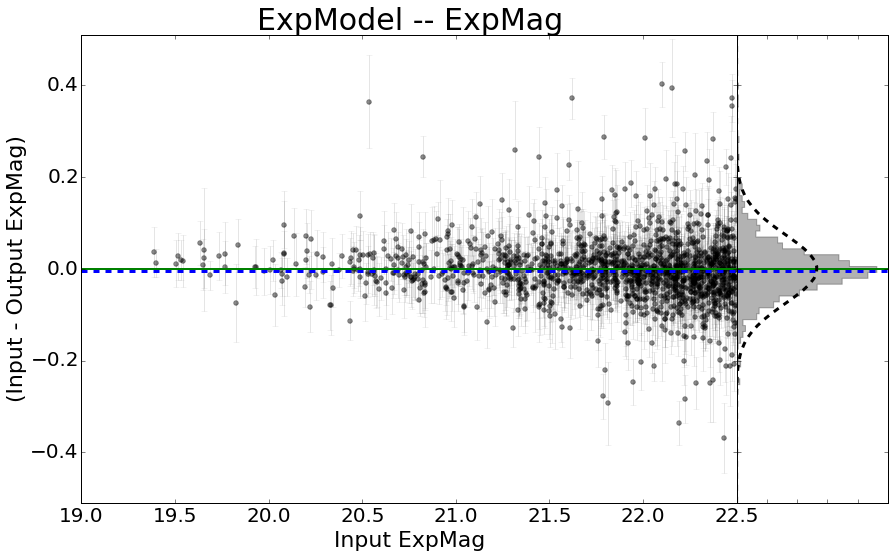

In [11]:
magOut = 'cmodel.exp.mag'
#magOut = 'cmodel.mag'
#magOut = 'mag.kron'
errOut = magOut + '.err' 
magArr = 'ExpMag'
#magArr = 'CModMag'
#magArr = 'KronMag'

refMag1 = expGood1['mag']
difMag1 = refMag1 - expGood1[magOut]
errMag1 = expGood1[errOut]
medMagDiff1 = np.median(difMag1)
print "The median magnitude offset between input and output is %7.4f mag" % medMagDiff1

axScat = plt.axes(recScat)
axHist = plt.axes(recHist)

# Scatter plot
axScat.tick_params(axis='both', which='major', labelsize=20)
axScat.set_xlabel('Input ExpMag', fontsize=22)
axScat.set_ylabel('(Input - Output ' + magArr + ')', fontsize=22)
axScat.set_title('ExpModel -- ' + magArr, fontsize=30)

axScat.scatter(refMag1, difMag1, marker='o', color='k', alpha=0.4)
axScat.errorbar(refMag1, difMag1, marker='.', color='k', ls='none', yerr=errMag1, alpha=0.1)
axScat.axhline(0.0, color='g', linewidth=2)
axScat.axhline(medMagDiff1, color='b', linestyle='--', linewidth=3)

axScat.set_xlim((19.0,  22.5))
axScat.set_ylim((-0.51, 0.51))

# Histogram 
n, bins, patches=axHist.hist(difMag1, bins=80, range=[-0.51, 0.52], 
                             orientation='horizontal', histtype='stepfilled', 
                             color='k', alpha=0.3, normed=1)
axHist.set_ylim(axScat.get_ylim())
axHist.axhline(0.0, color='g', linewidth=2)
axHist.axhline(medMagDiff1, color='b', linestyle='--', linewidth=3)

axHist.yaxis.set_major_formatter(NullFormatter())
axHist.xaxis.set_major_formatter(NullFormatter())

#gauMod = GMM(4).fit(difMag1)
#x = np.linspace(-0.51, 0.51, 1000)
#logprob, responsibilities = gauMod.score_samples(x)
#pdf = np.exp(logprob)
#axHist.plot(pdf, x, '-k')

# Best fit of data
(mu, sigma) = norm.fit(difMag1)
print "(mu, sigma) of difMag1 is (%6.3f, %6.3f)" % (mu, sigma)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(y, bins, 'k--', linewidth=3)

The median magnitude offset between input and output is -0.0032 mag for expUse2
The median magnitude offset between input and output is -0.0024 mag for expUse4
(mu, sigma) of difMag2 is ( 0.001,  0.051)
(mu, sigma) of difMag4 is ( 0.001,  0.048)


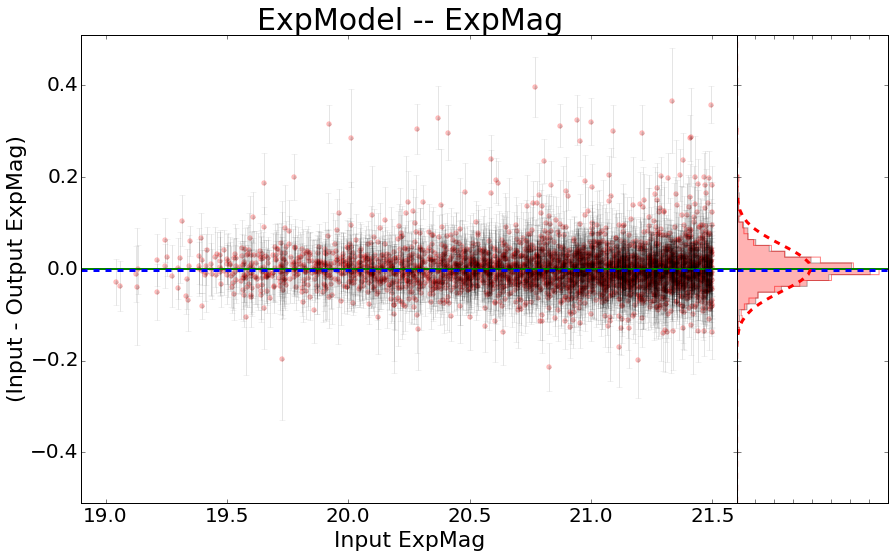

In [12]:
# For the bright end 
magOut = 'cmodel.exp.mag'
#magOut = 'cmodel.mag'
#magOut = 'mag.kron'
errOut = magOut + '.err' 
magArr = 'ExpMag'
#magArr = 'CModMag'
#magArr = 'KronMag'

refMag2 = expGood2['mag']
difMag2 = refMag2 - expGood2[magOut]
errMag2 = expGood2[errOut]
medMagDiff2 = np.median(difMag2)
print "The median magnitude offset between input and output is %7.4f mag for expUse2" % medMagDiff2

refMag4 = expGood4['mag']
difMag4 = refMag4 - expGood4[magOut]
errMag4 = expGood4[errOut]
medMagDiff4 = np.median(difMag4)
print "The median magnitude offset between input and output is %7.4f mag for expUse4" % medMagDiff4

axScat = plt.axes(recScat)
axHist = plt.axes(recHist)

# Scatter plot
axScat.tick_params(axis='both', which='major', labelsize=20)
axScat.set_xlabel('Input ExpMag', fontsize=22)
axScat.set_ylabel('(Input - Output ' + magArr + ')', fontsize=22)
axScat.set_title('ExpModel -- ' + magArr, fontsize=30)

axScat.errorbar(refMag2, difMag2, marker='.', color='k', ls='none', yerr=errMag2, alpha=0.1)
axScat.scatter(refMag2, difMag2, marker='o', color='r', alpha=0.2)
axScat.axhline(0.0, color='g', linewidth=2)
axScat.axhline(medMagDiff2, color='b', linestyle='--', linewidth=3)

axScat.errorbar(refMag4, difMag4, marker='.', color='k', ls='none', yerr=errMag4, alpha=0.1)
axScat.scatter(refMag4, difMag4, marker='o', color='r', alpha=0.2)

axScat.set_xlim((18.9,  21.6))
axScat.set_ylim((-0.51, 0.51))

# Histogram 
n, bins, patches=axHist.hist(difMag2, bins=80, range=[-0.51, 0.51], 
                             orientation='horizontal', histtype='stepfilled', 
                             color='r', alpha=0.3, normed=1)
n, bins, patches=axHist.hist(difMag4, bins=80, range=[-0.51, 0.51], 
                             orientation='horizontal', histtype='step', 
                             color='r', alpha=0.5, normed=1)
axHist.set_ylim(axScat.get_ylim())
axHist.axhline(0.0, color='g', linewidth=2)
axHist.axhline(medMagDiff2, color='b', linestyle='--', linewidth=3)

axHist.yaxis.set_major_formatter(NullFormatter())
axHist.xaxis.set_major_formatter(NullFormatter())

# Best fit of data
(mu, sigma) = norm.fit(difMag2)
print "(mu, sigma) of difMag2 is (%6.3f, %6.3f)" % (mu, sigma)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(y, bins, 'r--', linewidth=3)
(mu, sigma) = norm.fit(difMag4)
print "(mu, sigma) of difMag4 is (%6.3f, %6.3f)" % (mu, sigma)

The median magnitude offset between input and output is -0.0032 mag for expUse2
The median magnitude offset between input and output is -0.0150 mag for expUse4
(mu, sigma) of difMag2 is (-0.008,  0.161)
(mu, sigma) of difMag4 is (-0.007,  0.138)


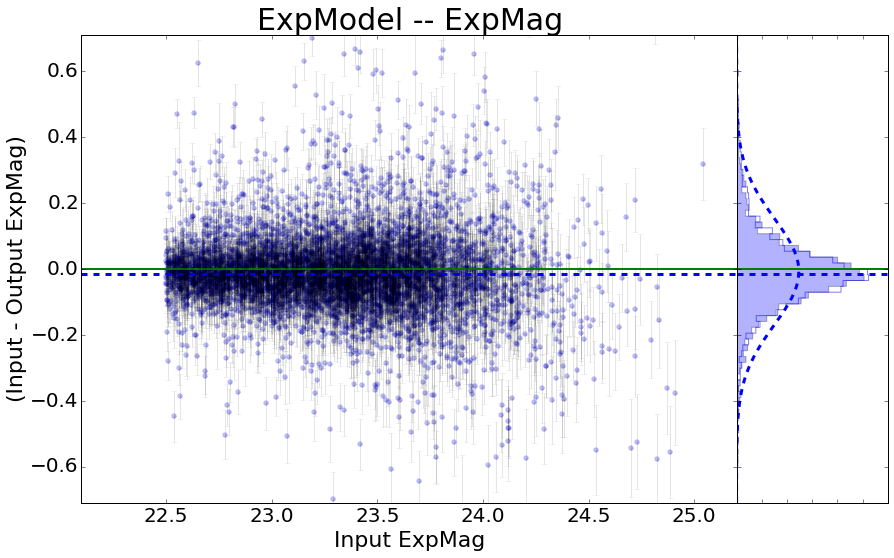

In [13]:
# For the faint end 
magOut = 'cmodel.exp.mag'
#magOut = 'cmodel.mag'
#magOut = 'mag.kron'
errOut = magOut + '.err' 
magArr = 'ExpMag'
#magArr = 'CModMag'
#magArr = 'KronMag'

refMag3 = expGood3['mag']
difMag3 = refMag3 - expGood3[magOut]
errMag3 = expGood3[errOut]
medMagDiff3 = np.median(difMag3)
print "The median magnitude offset between input and output is %7.4f mag for expUse2" % medMagDiff2

refMag5 = expGood5['mag']
difMag5 = refMag5 - expGood5[magOut]
errMag5 = expGood5[errOut]
medMagDiff5 = np.median(difMag5)
print "The median magnitude offset between input and output is %7.4f mag for expUse4" % medMagDiff5

axScat = plt.axes(recScat)
axHist = plt.axes(recHist)

# Scatter plot
axScat.tick_params(axis='both', which='major', labelsize=20)
axScat.set_xlabel('Input ExpMag', fontsize=22)
axScat.set_ylabel('(Input - Output ' + magArr + ')', fontsize=22)
axScat.set_title('ExpModel -- ' + magArr, fontsize=30)

axScat.errorbar(refMag3, difMag3, marker='.', color='k', ls='none', yerr=errMag3, alpha=0.1)
axScat.scatter(refMag3, difMag3, marker='o', color='b', alpha=0.2)
axScat.axhline(0.0, color='g', linewidth=2)
axScat.axhline(medMagDiff3, color='b', linestyle='--', linewidth=3)

axScat.errorbar(refMag5, difMag5, marker='.', color='k', ls='none', yerr=errMag5, alpha=0.1)
axScat.scatter(refMag5, difMag5, marker='o', color='b', alpha=0.2)

axScat.set_xlim((22.1,  25.2))
axScat.set_ylim((-0.71, 0.71))

# Histogram 
n, bins, patches=axHist.hist(difMag3, bins=80, range=[-0.71, 0.71], 
                             orientation='horizontal', histtype='stepfilled', 
                             color='b', alpha=0.3, normed=1)
n, bins, patches=axHist.hist(difMag5, bins=80, range=[-0.71, 0.71], 
                             orientation='horizontal', histtype='step', 
                             color='b', alpha=0.5, normed=1)
axHist.set_ylim(axScat.get_ylim())
axHist.axhline(0.0, color='g', linewidth=2)
axHist.axhline(medMagDiff3, color='b', linestyle='--', linewidth=3)

axHist.yaxis.set_major_formatter(NullFormatter())
axHist.xaxis.set_major_formatter(NullFormatter())

# Best fit of data
(mu, sigma) = norm.fit(difMag3)
print "(mu, sigma) of difMag2 is (%6.3f, %6.3f)" % (mu, sigma)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(y, bins, 'b--', linewidth=3)
(mu, sigma) = norm.fit(difMag5)
print "(mu, sigma) of difMag4 is (%6.3f, %6.3f)" % (mu, sigma)

# Size Difference 

The median Reff difference between the input and output is -0.0143 for ExpUse1
The median Reff difference between the input and output is -0.0187 for ExpUse2
The median Reff difference between the input and output is -0.0203 for ExpUse4
(mu, sigma) of difReff1 is (-0.022,  0.087)
(mu, sigma) of difReff2 is (-0.022,  0.085)
(mu, sigma) of difReff4 is (-0.028,  0.108)


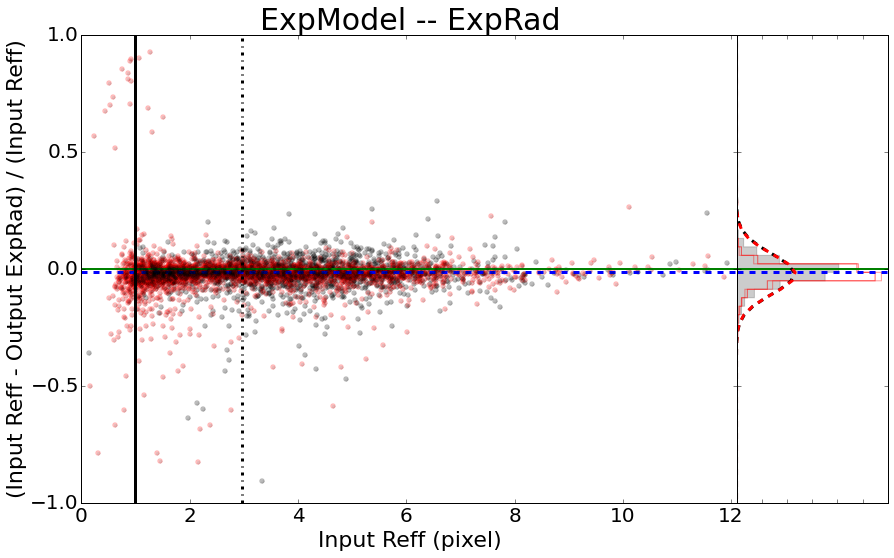

In [14]:
reffOut = 'cmodel.exp.ellipse_a'
reffArr = 'ExpRad'
#reffOut = 'cmodel.dev.ellipse_a'
#reffArr = 'DevRad'
#reffOut = 'shape.sdss_a' 
#reffArr = 'SdssRad'

# For random selected sample and the bright sample

refReff1 = expGood1['reff']
difReff1 = ( refReff1 - expGood1[reffOut] ) / refReff1
medReffDiff1 = np.median(difReff1)
print "The median Reff difference between the input and output is %7.4f for ExpUse1" % medReffDiff1

refReff2 = expGood2['reff'] 
difReff2 = ( refReff2 - expGood2[reffOut] ) / refReff2
medReffDiff2 = np.median(difReff2)
print "The median Reff difference between the input and output is %7.4f for ExpUse2" % medReffDiff2 

refReff4 = expGood4['reff'] 
difReff4 = ( refReff4 - expGood4[reffOut] ) / refReff4
medReffDiff4 = np.median(difReff4)
print "The median Reff difference between the input and output is %7.4f for ExpUse4" % medReffDiff4

axScat = plt.axes(recScat)
axHist = plt.axes(recHist)

# Scatter plot
axScat.tick_params(axis='both', which='major', labelsize=20)
axScat.set_xlabel('Input Reff (pixel)', fontsize=22)
axScat.set_ylabel('(Input Reff - Output ' + reffArr + ') / (Input Reff)', fontsize=22)
axScat.set_title('ExpModel -- ' + reffArr, fontsize=30)

axScat.errorbar(refReff1, difReff1, marker='.', color='k', ls='none', alpha=0.1)
axScat.scatter(refReff1, difReff1, marker='o', color='k', alpha=0.2)
axScat.axhline(0.0, color='g', linewidth=2)
axScat.axhline(medReffDiff1, color='b', linestyle='--', linewidth=3)

axScat.errorbar(refReff2, difReff2, marker='.', color='k', ls='none', alpha=0.1)
axScat.scatter(refReff2, difReff2, marker='o', color='r', alpha=0.2)

axScat.errorbar(refReff4, difReff4, marker='.', color='k', ls='none', alpha=0.1)
axScat.scatter(refReff4, difReff4, marker='o', color='r', alpha=0.2)

axScat.set_xlim((0.0,  12.1))
axScat.set_ylim((-1.0, 1.0))

# Vertical line that indicates the FWHM of a 1.0 arcsec seeing
axScat.axvline((0.5 / 0.168), color='k', linestyle='-.', linewidth=3)
axScat.axvline(1.0, color='k', linestyle='-', linewidth=3)

# Histogram 
n, bins, patches=axHist.hist(difReff1, bins=80, range=[-1.9, 1.0], 
                             orientation='horizontal', histtype='stepfilled', 
                             color='k', alpha=0.2, normed=1)
n, bins, patches=axHist.hist(difReff2, bins=80, range=[-1.9, 1.0], 
                             orientation='horizontal', histtype='step', 
                             color='r', alpha=0.6, normed=1)
n, bins, patches=axHist.hist(difReff4, bins=80, range=[-1.9, 1.0], 
                             orientation='horizontal', histtype='step', 
                             color='r', alpha=0.4, normed=1)
axHist.set_ylim(axScat.get_ylim())
axHist.axhline(0.0, color='g', linewidth=2)
axHist.axhline(medReffDiff1, color='b', linestyle='--', linewidth=3)

axHist.yaxis.set_major_formatter(NullFormatter())
axHist.xaxis.set_major_formatter(NullFormatter())

# Best fit of data
(mu, sigma) = norm.fit(difReff1)
print "(mu, sigma) of difReff1 is (%6.3f, %6.3f)" % (mu, sigma)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(y, bins, 'k--', linewidth=3)

(mu, sigma) = norm.fit(difReff2)
print "(mu, sigma) of difReff2 is (%6.3f, %6.3f)" % (mu, sigma)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(y, bins, 'r--', linewidth=3)
(mu, sigma) = norm.fit(difReff4)
print "(mu, sigma) of difReff4 is (%6.3f, %6.3f)" % (mu, sigma)

The median Reff difference between the input and output is -0.0261 for ExpUse3
The median Reff difference between the input and output is -0.0303 for ExpUse5
(mu, sigma) of difReff3 is (-0.073,  0.497)
(mu, sigma) of difReff5 is (-0.073,  0.462)


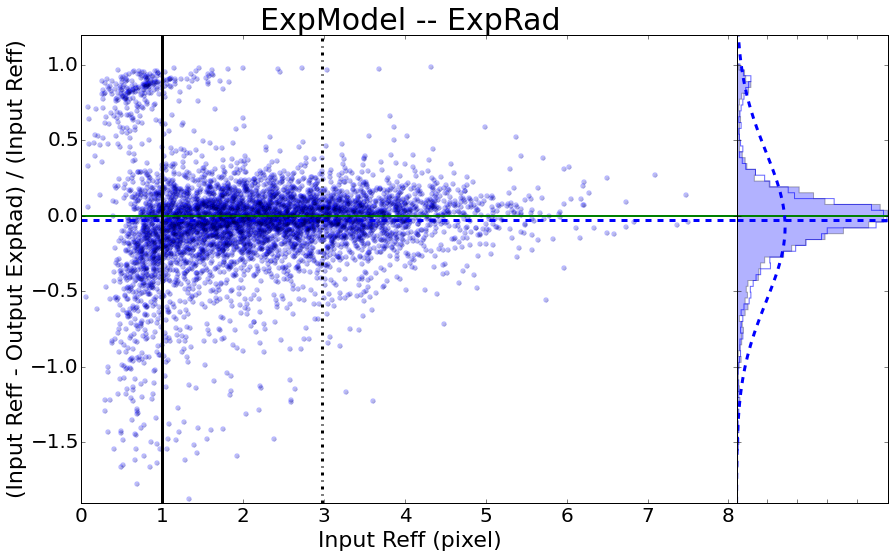

In [15]:
reffOut = 'cmodel.exp.ellipse_a'
reffArr = 'ExpRad'
#reffOut = 'cmodel.dev.ellipse_a'
#reffArr = 'DevRad'
#reffOut = 'shape.sdss_a' 
#reffArr = 'SdssRad'

# For the faint sample

refReff3 = expGood3['reff'] 
difReff3 = ( refReff3 - expGood3[reffOut] ) / refReff3
medReffDiff3 = np.median(difReff3)
print "The median Reff difference between the input and output is %7.4f for ExpUse3" % medReffDiff3

refReff5 = expGood5['reff'] 
difReff5 = ( refReff5 - expGood5[reffOut] ) / refReff5
medReffDiff5 = np.median(difReff5)
print "The median Reff difference between the input and output is %7.4f for ExpUse5" % medReffDiff5

axScat = plt.axes(recScat)
axHist = plt.axes(recHist)

# Scatter plot
axScat.tick_params(axis='both', which='major', labelsize=20)
axScat.set_xlabel('Input Reff (pixel)', fontsize=22)
axScat.set_ylabel('(Input Reff - Output ' + reffArr + ') / (Input Reff)', fontsize=22)
axScat.set_title('ExpModel -- ' + reffArr, fontsize=30)

axScat.errorbar(refReff3, difReff3, marker='.', color='k', ls='none', alpha=0.1)
axScat.scatter(refReff3, difReff3, marker='o', color='b', alpha=0.2)
axScat.axhline(0.0, color='g', linewidth=2)
axScat.axhline(medReffDiff3, color='b', linestyle='--', linewidth=3)

axScat.errorbar(refReff5, difReff5, marker='.', color='k', ls='none', alpha=0.1)
axScat.scatter(refReff5, difReff5, marker='o', color='b', alpha=0.2)

axScat.set_xlim((0.0,  8.1))
axScat.set_ylim((-1.9, 1.2))

# Vertical line that indicates the FWHM of a 1.0 arcsec seeing
axScat.axvline((0.5 / 0.168), color='k', linestyle='-.', linewidth=3)
axScat.axvline(1.0, color='k', linestyle='-', linewidth=3)

# Histogram 
n, bins, patches=axHist.hist(difReff3, bins=80, range=[-1.9, 1.2], 
                             orientation='horizontal', histtype='stepfilled', 
                             color='b', alpha=0.3, normed=1)
n, bins, patches=axHist.hist(difReff5, bins=80, range=[-1.9, 1.2], 
                             orientation='horizontal', histtype='step', 
                             color='b', alpha=0.6, normed=1)
axHist.set_ylim(axScat.get_ylim())
axHist.axhline(0.0, color='g', linewidth=2)
axHist.axhline(medReffDiff3, color='b', linestyle='--', linewidth=3)

axHist.yaxis.set_major_formatter(NullFormatter())
axHist.xaxis.set_major_formatter(NullFormatter())

# Best fit of data
(mu, sigma) = norm.fit(difReff3)
print "(mu, sigma) of difReff3 is (%6.3f, %6.3f)" % (mu, sigma)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(y, bins, 'b--', linewidth=3)

(mu, sigma) = norm.fit(difReff5)
print "(mu, sigma) of difReff5 is (%6.3f, %6.3f)" % (mu, sigma)

# Shape Difference 
## Axis Ratio

In [16]:
baOut = 'cmodel.exp.ellipse_q'
baArr = 'ExpBa'
#baOut = 'cmodel.dev.ellipse_q'
#baArr = 'DevBa'
#baOut = 'shape.sdss_q' 
#baArr = 'SdssBa'

# For random selected sample

refBa1 = expGood1['b_a'] 
difBa1 = (refBa1 - expGood1[baOut]) / refBa1
medBaDiff1 = np.median(difBa1)
print "The median b/a difference between the input and output is %7.4f for ExpUse1" % medBaDiff1

# For bright sample

refBa2 = expGood2['b_a'] 
difBa2 = (refBa2 - expGood2[baOut]) / refBa2
medBaDiff2 = np.median(difBa2)
print "The median b/a difference between the input and output is %7.4f for ExpUse2" % medBaDiff2

refBa4 = expGood4['b_a'] 
difBa4 = (refBa4 - expGood4[baOut]) / refBa4
medBaDiff4 = np.median(difBa4)
print "The median b/a difference between the input and output is %7.4f for ExpUse4" % medBaDiff4


axScat = plt.axes(recScat)
axHist = plt.axes(recHist)

# Scatter plot
axScat.tick_params(axis='both', which='major', labelsize=20)
axScat.set_xlabel('Input (B/A)', fontsize=22)
axScat.set_ylabel('(Input B/A - Output ' + baArr + ') / (Input B/A)', fontsize=22)
axScat.set_title('ExpModel -- ' + baArr, fontsize=30)

axScat.errorbar(refBa1, difBa1, marker='.', color='k', ls='none', alpha=0.1)
axScat.scatter(refBa1, difBa1, marker='o', color='k', alpha=0.2)
axScat.axhline(0.0, color='g', linewidth=2)
axScat.axhline(medBaDiff1, color='b', linestyle='--', linewidth=3)

axScat.errorbar(refBa2, difBa2, marker='.', color='k', ls='none', alpha=0.1)
axScat.scatter(refBa2, difBa2, marker='o', color='r', alpha=0.2)

axScat.errorbar(refBa4, difBa4, marker='.', color='k', ls='none', alpha=0.1)
axScat.scatter(refBa4, difBa4, marker='o', color='r', alpha=0.2)

axScat.set_xlim((0.20, 0.99))
axScat.set_ylim((-0.8, 0.8))

# Histogram 
n, bins, patches=axHist.hist(difBa1, bins=80, range=[-0.8, 0.8], 
                             orientation='horizontal', histtype='stepfilled', 
                             color='k', alpha=0.2, normed=1)
n, bins, patches=axHist.hist(difBa2, bins=80, range=[-0.8, 0.8], 
                             orientation='horizontal', histtype='step', 
                             color='r', alpha=0.6, normed=1)
n, bins, patches=axHist.hist(difBa4, bins=80, range=[-0.8, 0.8], 
                             orientation='horizontal', histtype='step', 
                             color='r', alpha=0.4, normed=1)
axHist.set_ylim(axScat.get_ylim())
axHist.axhline(0.0, color='g', linewidth=2)
axHist.axhline(medBaDiff1, color='b', linestyle='--', linewidth=3)

axHist.yaxis.set_major_formatter(NullFormatter())
axHist.xaxis.set_major_formatter(NullFormatter())

# Best fit of data
(mu, sigma) = norm.fit(difBa1)
print "(mu, sigma) of difBa1 is (%6.3f, %6.3f)" % (mu, sigma)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(y, bins, 'k--', linewidth=3)

(mu, sigma) = norm.fit(difBa2)
print "(mu, sigma) of difBa2 is (%6.3f, %6.3f)" % (mu, sigma)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(y, bins, 'r--', linewidth=3)
(mu, sigma) = norm.fit(difBa4)
print "(mu, sigma) of difBa4 is (%6.3f, %6.3f)" % (mu, sigma)

The median b/a difference between the input and output is  0.0040 for ExpUse1
The median b/a difference between the input and output is  0.0020 for ExpUse2
The median b/a difference between the input and output is  0.0007 for ExpUse4
(mu, sigma) of difBa1 is ( 0.003,  0.088)
(mu, sigma) of difBa2 is ( 0.006,  0.083)
(mu, sigma) of difBa4 is ( 0.008,  0.085)


The median b/a difference between the input and output is  0.1111 for ExpUse3
The median b/a difference between the input and output is  0.1153 for ExpUse5
(mu, sigma) of difBa3 is ( 0.157,  0.323)
(mu, sigma) of difBa5 is ( 0.154,  0.321)


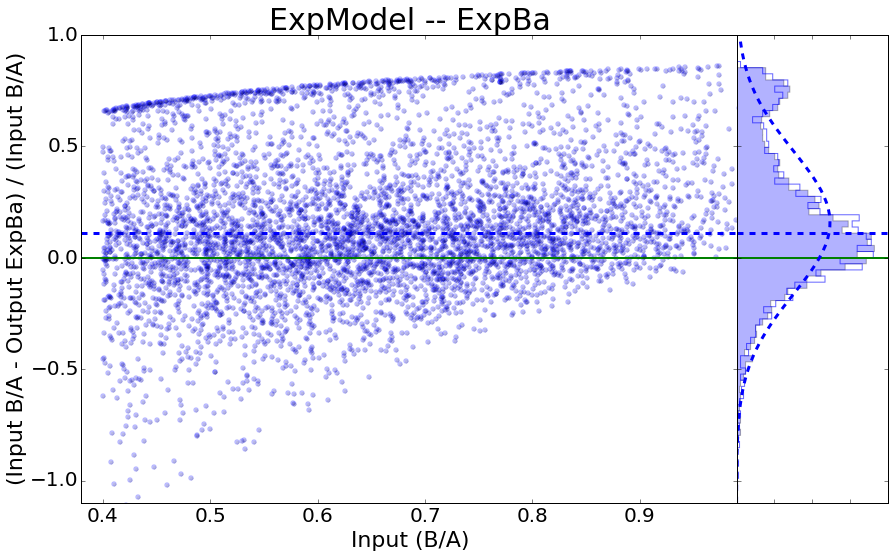

In [17]:
baOut = 'cmodel.exp.ellipse_q'
baArr = 'ExpBa'
#baOut = 'cmodel.dev.ellipse_q'
#baArr = 'DevBa'
#baOut = 'shape.sdss_q' 
#baArr = 'SdssBa'

# For faint sample

refBa3 = expGood3['b_a'] 
difBa3 = (refBa3 - expGood3[baOut]) / refBa3
medBaDiff3 = np.median(difBa3)
print "The median b/a difference between the input and output is %7.4f for ExpUse3" % medBaDiff3

refBa5 = expGood5['b_a'] 
difBa5 = (refBa5 - expGood5[baOut]) / refBa5
medBaDiff5 = np.median(difBa5)
print "The median b/a difference between the input and output is %7.4f for ExpUse5" % medBaDiff5

axScat = plt.axes(recScat)
axHist = plt.axes(recHist)

# Scatter plot
axScat.tick_params(axis='both', which='major', labelsize=20)
axScat.set_xlabel('Input (B/A)', fontsize=22)
axScat.set_ylabel('(Input B/A - Output ' + baArr + ') / (Input B/A)', fontsize=22)
axScat.set_title('ExpModel -- ' + baArr, fontsize=30)

axScat.errorbar(refBa3, difBa3, marker='.', color='k', ls='none', alpha=0.1)
axScat.scatter(refBa3, difBa3, marker='o', color='b', alpha=0.2)
axScat.axhline(0.0, color='g', linewidth=2)
axScat.axhline(medBaDiff3, color='b', linestyle='--', linewidth=3)

axScat.errorbar(refBa5, difBa5, marker='.', color='k', ls='none', alpha=0.1)
axScat.scatter(refBa5, difBa5, marker='o', color='b', alpha=0.2)

axScat.set_xlim((0.38, 0.99))
axScat.set_ylim((-1.1, 1.0))

# Histogram 
n, bins, patches=axHist.hist(difBa3, bins=80, range=[-1.1, 1.1], 
                             orientation='horizontal', histtype='stepfilled', 
                             color='b', alpha=0.3, normed=1)
n, bins, patches=axHist.hist(difBa5, bins=80, range=[-1.1, 1.1], 
                             orientation='horizontal', histtype='step', 
                             color='b', alpha=0.6, normed=1)
axHist.set_ylim(axScat.get_ylim())
axHist.axhline(0.0, color='g', linewidth=2)
axHist.axhline(medBaDiff3, color='b', linestyle='--', linewidth=3)

axHist.yaxis.set_major_formatter(NullFormatter())
axHist.xaxis.set_major_formatter(NullFormatter())

# Best fit of data
(mu, sigma) = norm.fit(difBa3)
print "(mu, sigma) of difBa3 is (%6.3f, %6.3f)" % (mu, sigma)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(y, bins, 'b--', linewidth=3)

(mu, sigma) = norm.fit(difBa5)
print "(mu, sigma) of difBa5 is (%6.3f, %6.3f)" % (mu, sigma)

## Position Angle

The median PA difference between the input and output is  0.0314 for ExpGood1
The median PA difference between the input and output is -0.0172 for ExpGood2
The median PA difference between the input and output is  0.0244 for ExpGood4
(mu, sigma) of difPa1 is (-1.213, 27.873)
(mu, sigma) of difPa2 is (-0.751, 30.785)
(mu, sigma) of difPa4 is (-0.320, 30.267)


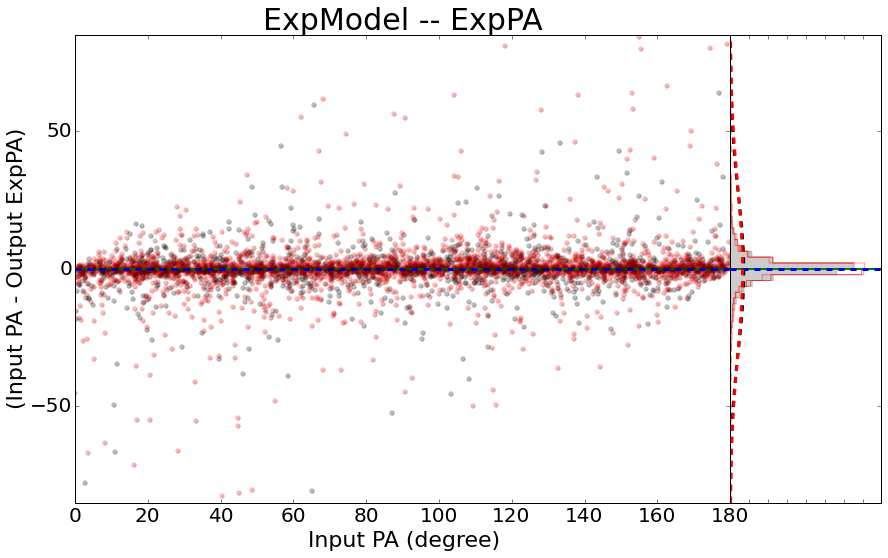

In [18]:
paOut = 'cmodel.exp.ellipse_theta'
paArr = 'ExpPA'
#paOut = 'cmodel.dev.ellipse_theta'
#paArr = 'DevPA'
#paOut = 'shape.sdss_theta' 
#paArr = 'SdssPA'

import angles 

# For random selected sample
refPa1 = map(lambda x : angles.normalize(x, 0.0, 180.0), [i for i in expGood1['theta']])
outPaCor = expGood1[paOut] - expGood1['thetaNorth']
outPa1 = map(lambda x : angles.normalize(x, 0.0, 180.0), [i for i in outPaCor])
           
difPa1 = (np.array(refPa1) - np.array(outPa1))
medPaDiff1 = np.median(difPa1)
print "The median PA difference between the input and output is %7.4f for ExpGood1" % medPaDiff1

# For bright sample
refPa2 = map(lambda x : angles.normalize(x, 0.0, 180.0), [i for i in expGood2['theta']])
outPaCor = expGood2[paOut] - expGood2['thetaNorth']
outPa2 = map(lambda x : angles.normalize(x, 0.0, 180.0), [i for i in outPaCor])
           
difPa2 = (np.array(refPa2) - np.array(outPa2))
medPaDiff2 = np.median(difPa2)
print "The median PA difference between the input and output is %7.4f for ExpGood2" % medPaDiff2

refPa4 = map(lambda x : angles.normalize(x, 0.0, 180.0), [i for i in expGood4['theta']])
outPaCor = expGood4[paOut] - expGood4['thetaNorth']
outPa4 = map(lambda x : angles.normalize(x, 0.0, 180.0), [i for i in outPaCor])
           
difPa4 = (np.array(refPa4) - np.array(outPa4))
medPaDiff4 = np.median(difPa4)
print "The median PA difference between the input and output is %7.4f for ExpGood4" % medPaDiff4

axScat = plt.axes(recScat)
axHist = plt.axes(recHist)

# Scatter plot
axScat.tick_params(axis='both', which='major', labelsize=20)
axScat.set_xlabel('Input PA (degree)', fontsize=22)
axScat.set_ylabel('(Input PA - Output ' + paArr + ')', fontsize=22)
axScat.set_title('ExpModel -- ' + paArr, fontsize=30)

axScat.errorbar(refPa1, difPa1, marker='.', color='k', ls='none', alpha=0.1)
axScat.scatter(refPa1, difPa1, marker='o', color='k', alpha=0.2)
axScat.axhline(0.0, color='g', linewidth=2)
axScat.axhline(medPaDiff1, color='b', linestyle='--', linewidth=3)

axScat.errorbar(refPa2, difPa2, marker='.', color='k', ls='none', alpha=0.1)
axScat.scatter(refPa2, difPa2, marker='o', color='r', alpha=0.2)

axScat.errorbar(refPa4, difPa4, marker='.', color='k', ls='none', alpha=0.1)
axScat.scatter(refPa4, difPa4, marker='o', color='r', alpha=0.2)

axScat.set_xlim((0.00, 180.0))
axScat.set_ylim((-85.0, 85.0))

# Histogram 
n, bins, patches=axHist.hist(difPa1, bins=80, range=[-85.0, 85.0], 
                             orientation='horizontal', histtype='stepfilled', 
                             color='k', alpha=0.2, normed=1)
n, bins, patches=axHist.hist(difPa2, bins=80, range=[-85.0, 85.0], 
                             orientation='horizontal', histtype='step', 
                             color='r', alpha=0.6, normed=1)
n, bins, patches=axHist.hist(difPa4, bins=80, range=[-85.0, 85.0], 
                             orientation='horizontal', histtype='step', 
                             color='r', alpha=0.4, normed=1)
axHist.set_ylim(axScat.get_ylim())
axHist.axhline(0.0, color='g', linewidth=2)
axHist.axhline(medPaDiff1, color='b', linestyle='--', linewidth=3)

axHist.yaxis.set_major_formatter(NullFormatter())
axHist.xaxis.set_major_formatter(NullFormatter())

# Best fit of data
(mu, sigma) = norm.fit(difPa1)
print "(mu, sigma) of difPa1 is (%6.3f, %6.3f)" % (mu, sigma)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(y, bins, 'k--', linewidth=3)

(mu, sigma) = norm.fit(difPa2)
print "(mu, sigma) of difPa2 is (%6.3f, %6.3f)" % (mu, sigma)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(y, bins, 'r--', linewidth=3)
(mu, sigma) = norm.fit(difPa4)
print "(mu, sigma) of difPa4 is (%6.3f, %6.3f)" % (mu, sigma)

The median PA difference between the input and output is -0.0440 for ExpGood3
The median PA difference between the input and output is  0.5584 for ExpGood5
(mu, sigma) of difBa3 is (-0.699, 51.408)
(mu, sigma) of difBa5 is ( 1.044, 51.602)


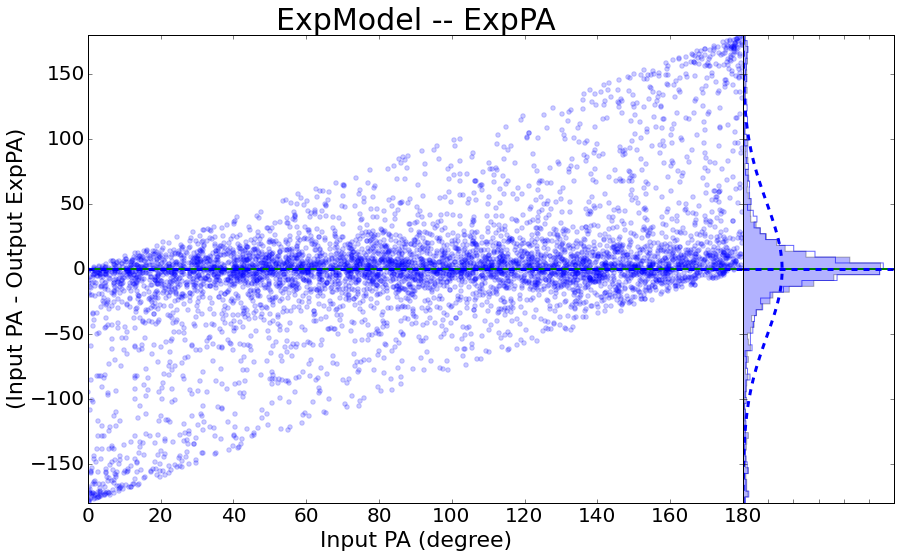

In [19]:
paOut = 'cmodel.exp.ellipse_theta'
paArr = 'ExpPA'
#paOut = 'cmodel.dev.ellipse_theta'
#paArr = 'DevPA'
#paOut = 'shape.sdss_theta' 
#paArr = 'SdssPA'

# For faint sample
refPa3 = map(lambda x : angles.normalize(x, 0.0, 180.0), [i for i in expGood3['theta']])
outPaCor = expGood3[paOut] - expGood3['thetaNorth']
outPa3 = map(lambda x : angles.normalize(x, 0.0, 180.0), [i for i in outPaCor])
           
difPa3 = (np.array(refPa3) - np.array(outPa3))
medPaDiff3 = np.median(difPa3)
print "The median PA difference between the input and output is %7.4f for ExpGood3" % medPaDiff3

refPa5 = map(lambda x : angles.normalize(x, 0.0, 180.0), [i for i in expGood5['theta']])
outPaCor = expGood5[paOut] - expGood5['thetaNorth']
outPa5 = map(lambda x : angles.normalize(x, 0.0, 180.0), [i for i in outPaCor])
           
difPa5 = (np.array(refPa5) - np.array(outPa5))
medPaDiff5 = np.median(difPa5)
print "The median PA difference between the input and output is %7.4f for ExpGood5" % medPaDiff5

axScat = plt.axes(recScat)
axHist = plt.axes(recHist)

# Scatter plot
axScat.tick_params(axis='both', which='major', labelsize=20)
axScat.set_xlabel('Input PA (degree)', fontsize=22)
axScat.set_ylabel('(Input PA - Output ' + paArr + ')', fontsize=22)
axScat.set_title('ExpModel -- ' + paArr, fontsize=30)

axScat.scatter(refPa3, difPa3, marker='o', color='b', alpha=0.2)
axScat.axhline(0.0, color='g', linewidth=2)
axScat.axhline(medPaDiff3, color='b', linestyle='--', linewidth=3)

axScat.scatter(refPa5, difPa5, marker='o', color='b', alpha=0.2)

axScat.set_xlim((0.00, 180.0))
axScat.set_ylim((-180.0, 180.0))

# Histogram 
n, bins, patches=axHist.hist(difPa3, bins=80, range=[-180.0, 180.0], 
                             orientation='horizontal', histtype='stepfilled', 
                             color='b', alpha=0.3, normed=1)
n, bins, patches=axHist.hist(difPa5, bins=80, range=[-180.0, 180.0], 
                             orientation='horizontal', histtype='step', 
                             color='b', alpha=0.6, normed=1)
axHist.set_ylim(axScat.get_ylim())
axHist.axhline(0.0, color='g', linewidth=2)
axHist.axhline(medPaDiff3, color='b', linestyle='--', linewidth=3)

axHist.yaxis.set_major_formatter(NullFormatter())
axHist.xaxis.set_major_formatter(NullFormatter())

# Best fit of data
(mu, sigma) = norm.fit(difPa3)
print "(mu, sigma) of difBa3 is (%6.3f, %6.3f)" % (mu, sigma)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(y, bins, 'b--', linewidth=3)

(mu, sigma) = norm.fit(difPa5)
print "(mu, sigma) of difBa5 is (%6.3f, %6.3f)" % (mu, sigma)

# Dependence of error on other parameters

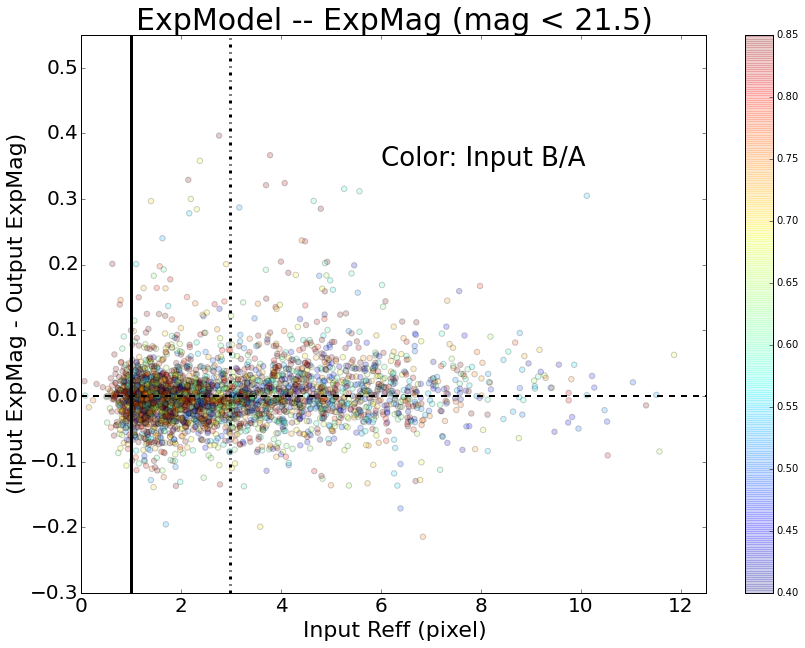

In [20]:
# Scatter plot
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Input Reff (pixel)', fontsize=22)
plt.ylabel('(Input ExpMag - Output ' + magArr + ')', fontsize=22)
plt.title('ExpModel -- ' + magArr + ' (mag < 21.5)', fontsize=30)

plt.scatter(refReff2, difMag2, marker='o', c=refBa2, alpha=0.2, s=30,
            vmin=0.4, vmax=0.85)
plt.scatter(refReff4, difMag4, marker='o', c=refBa4, alpha=0.2, s=30,
            vmin=0.4, vmax=0.85)
plt.axhline(0.0, color='k', linewidth=2, linestyle='--')

# Vertical line that indicates the FWHM of a 1.0 arcsec seeing
plt.axvline((0.5 / 0.168), color='k', linestyle='-.', linewidth=3)
plt.axvline(1.0, color='k', linestyle='-', linewidth=3)

plt.xlim((0.0, 12.5))
plt.ylim((-0.30, 0.55))

plt.colorbar()

plt.text(6.0, 0.35, 'Color: Input B/A', fontsize=26)

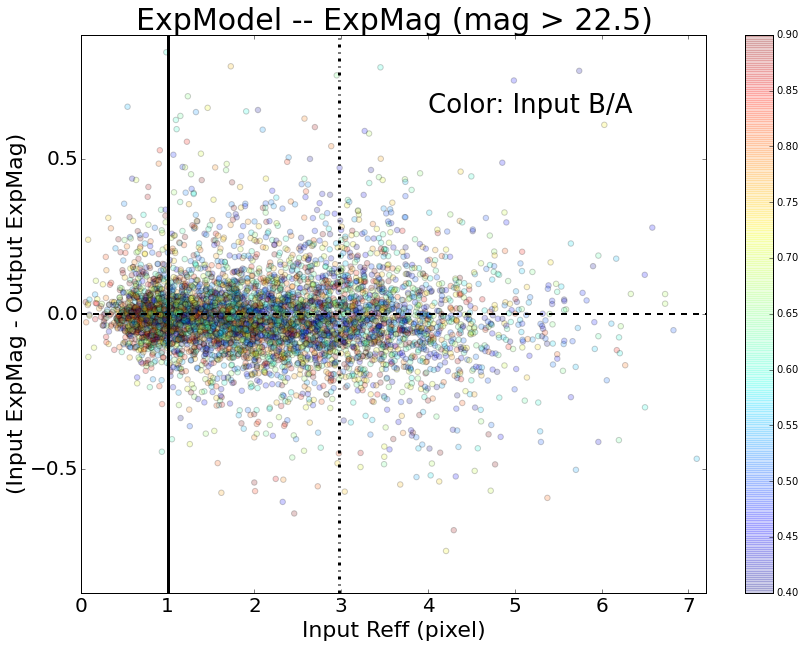

In [21]:
# Scatter plot
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Input Reff (pixel)', fontsize=22)
plt.ylabel('(Input ExpMag - Output ' + magArr + ')', fontsize=22)
plt.title('ExpModel -- ' + magArr + ' (mag > 22.5)', fontsize=30)

plt.scatter(refReff3, difMag3, marker='o', c=refBa3, alpha=0.2, s=30,
            vmin=0.4, vmax=0.9)
plt.scatter(refReff5, difMag5, marker='o', c=refBa5, alpha=0.2, s=30,
            vmin=0.4, vmax=0.9)
plt.axhline(0.0, color='k', linewidth=2, linestyle='--')

# Vertical line that indicates the FWHM of a 1.0 arcsec seeing
plt.axvline((0.5 / 0.168), color='k', linestyle='-.', linewidth=3)
plt.axvline(1.0, color='k', linestyle='-', linewidth=3)

plt.xlim((0.0, 7.2))
plt.ylim((-0.90, 0.9))

plt.colorbar()

plt.text(4.0, 0.65, 'Color: Input B/A', fontsize=26)

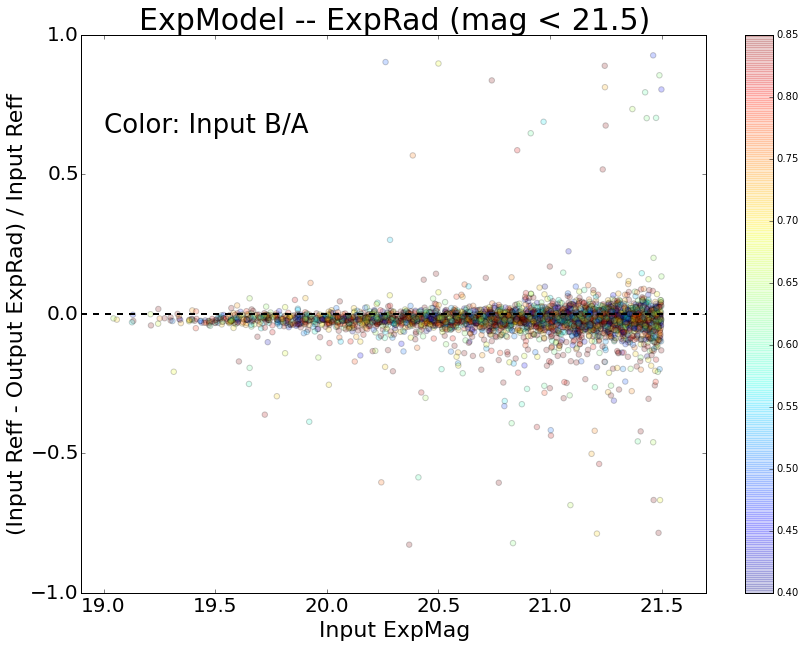

In [22]:
# Scatter plot
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Input ExpMag', fontsize=22)
plt.ylabel('(Input Reff - Output ' + reffArr + ') / Input Reff', fontsize=22)
plt.title('ExpModel -- ' + reffArr + ' (mag < 21.5)', fontsize=30)

plt.scatter(refMag2, difReff2, marker='o', c=refBa2, alpha=0.2, s=30,
            vmin=0.4, vmax=0.85)
plt.scatter(refMag4, difReff4, marker='o', c=refBa4, alpha=0.2, s=30,
            vmin=0.4, vmax=0.85)
plt.axhline(0.0, color='k', linewidth=2, linestyle='--')

plt.xlim((18.9, 21.7))
plt.ylim((-1.00, 1.00))

plt.colorbar()

plt.text(19.0, 0.65, 'Color: Input B/A', fontsize=26)

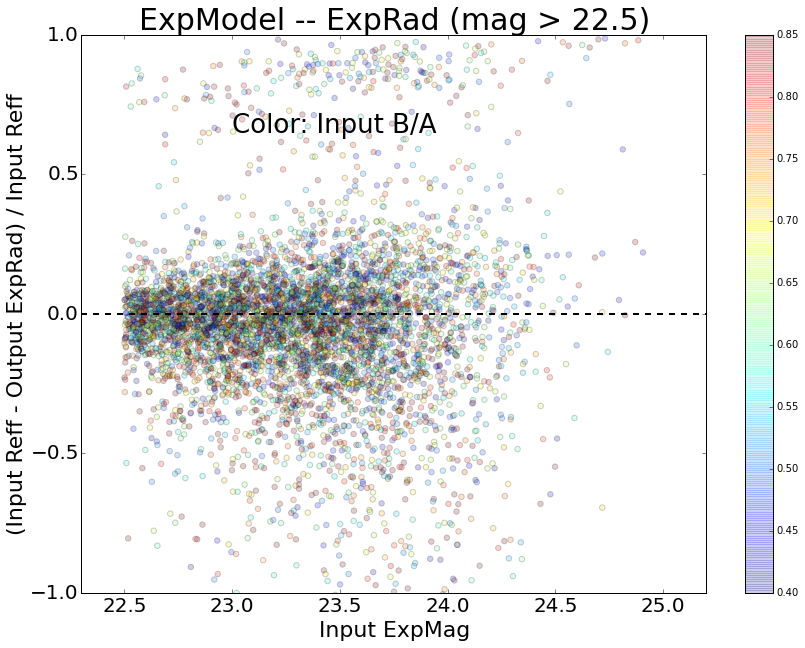

In [23]:
# Scatter plot
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Input ExpMag', fontsize=22)
plt.ylabel('(Input Reff - Output ' + reffArr + ') / Input Reff', fontsize=22)
plt.title('ExpModel -- ' + reffArr + ' (mag > 22.5)', fontsize=30)

plt.scatter(refMag3, difReff3, marker='o', c=refBa3, alpha=0.2, s=30,
            vmin=0.4, vmax=0.85)
plt.scatter(refMag5, difReff5, marker='o', c=refBa5, alpha=0.2, s=30,
            vmin=0.4, vmax=0.85)
plt.axhline(0.0, color='k', linewidth=2, linestyle='--')

plt.xlim((22.3, 25.2))
plt.ylim((-1.00, 1.00))

plt.colorbar()

plt.text(23.0, 0.65, 'Color: Input B/A', fontsize=26)

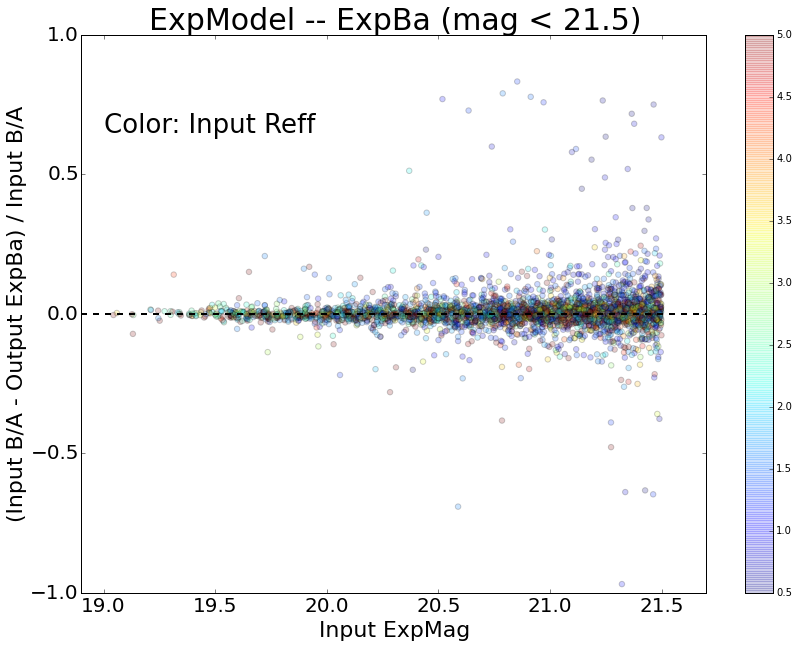

In [24]:
# Scatter plot
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Input ExpMag', fontsize=22)
plt.ylabel('(Input B/A - Output ' + baArr + ') / Input B/A', fontsize=22)
plt.title('ExpModel -- ' + baArr + ' (mag < 21.5)', fontsize=30)

plt.scatter(refMag2, difBa2, marker='o', c=refReff2, alpha=0.2, s=30,
            vmin=0.5, vmax=5.0)
plt.scatter(refMag4, difBa4, marker='o', c=refReff4, alpha=0.2, s=30,
            vmin=0.5, vmax=5.0)
plt.axhline(0.0, color='k', linewidth=2, linestyle='--')

plt.xlim((18.9, 21.7))
plt.ylim((-1.00, 1.00))

plt.colorbar()

plt.text(19.0, 0.65, 'Color: Input Reff', fontsize=26)

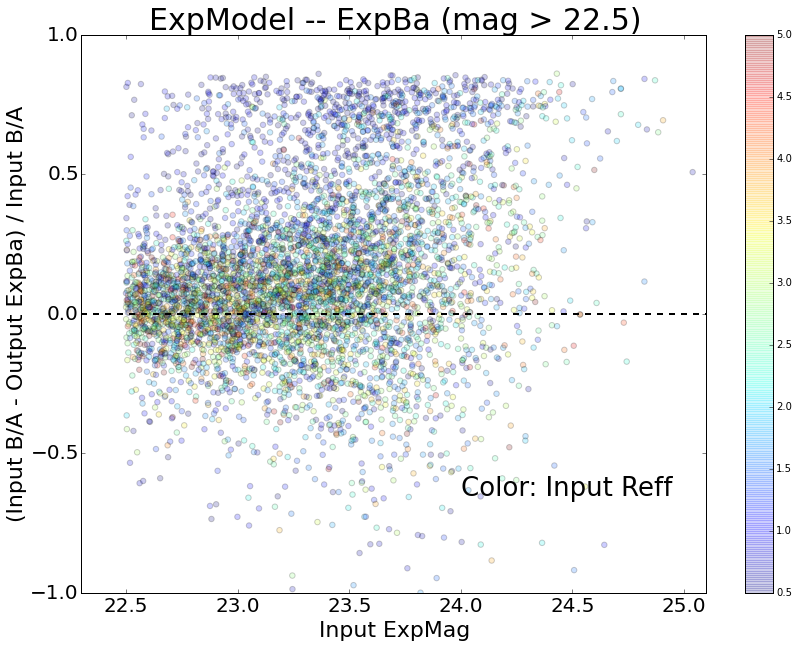

In [25]:
# Scatter plot
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Input ExpMag', fontsize=22)
plt.ylabel('(Input B/A - Output ' + baArr + ') / Input B/A', fontsize=22)
plt.title('ExpModel -- ' + baArr + ' (mag > 22.5)', fontsize=30)

plt.scatter(refMag3, difBa3, marker='o', c=refReff3, alpha=0.2, s=30,
            vmin=0.5, vmax=5.0)
plt.scatter(refMag5, difBa5, marker='o', c=refReff5, alpha=0.2, s=30,
            vmin=0.5, vmax=5.0)
plt.axhline(0.0, color='k', linewidth=2, linestyle='--')

plt.xlim((22.3, 25.1))
plt.ylim((-1.00, 1.00))

plt.colorbar()

plt.text(24.0, -0.65, 'Color: Input Reff', fontsize=26)

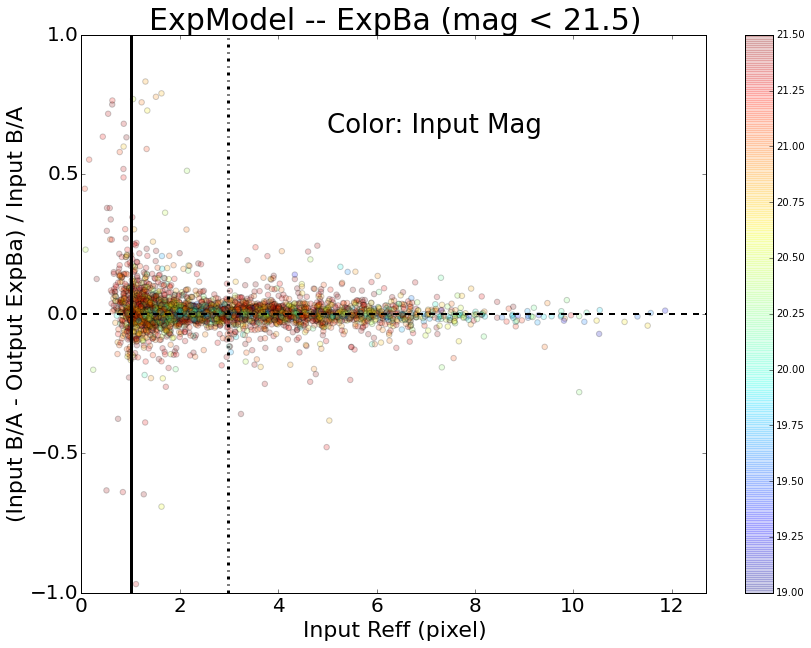

In [26]:
# Scatter plot
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Input Reff (pixel)', fontsize=22)
plt.ylabel('(Input B/A - Output ' + baArr + ') / Input B/A', fontsize=22)
plt.title('ExpModel -- ' + baArr + ' (mag < 21.5)', fontsize=30)

plt.scatter(refReff2, difBa2, marker='o', c=refMag2, alpha=0.2, s=30,
            vmin=19, vmax=21.5)
plt.scatter(refReff4, difBa4, marker='o', c=refMag4, alpha=0.2, s=30,
            vmin=19, vmax=21.5)
plt.axhline(0.0, color='k', linewidth=2, linestyle='--')

# Vertical line that indicates the FWHM of a 1.0 arcsec seeing
plt.axvline((0.5 / 0.168), color='k', linestyle='-.', linewidth=3)
plt.axvline(1.0, color='k', linestyle='-', linewidth=3)

plt.xlim((0.0, 12.7))
plt.ylim((-1.00, 1.00))

plt.colorbar()

plt.text(5.0, 0.65, 'Color: Input Mag', fontsize=26)

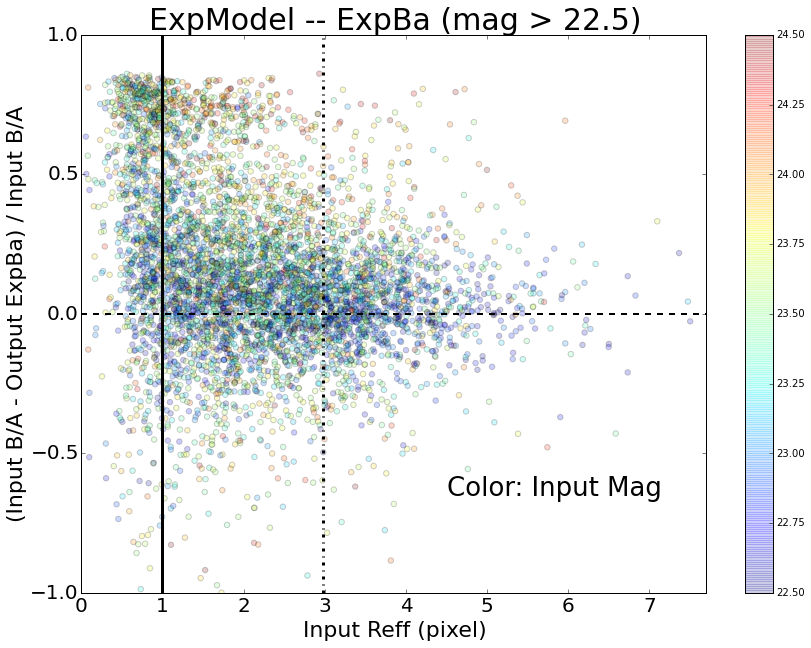

In [27]:
# Scatter plot
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Input Reff (pixel)', fontsize=22)
plt.ylabel('(Input B/A - Output ' + baArr + ') / Input B/A', fontsize=22)
plt.title('ExpModel -- ' + baArr + ' (mag > 22.5)', fontsize=30)

plt.scatter(refReff3, difBa3, marker='o', c=refMag3, alpha=0.2, s=30,
            vmin=22.5, vmax=24.5)
plt.scatter(refReff5, difBa5, marker='o', c=refMag5, alpha=0.2, s=30,
            vmin=22.5, vmax=24.5)
plt.axhline(0.0, color='k', linewidth=2, linestyle='--')

# Vertical line that indicates the FWHM of a 1.0 arcsec seeing
plt.axvline((0.5 / 0.168), color='k', linestyle='-.', linewidth=3)
plt.axvline(1.0, color='k', linestyle='-', linewidth=3)

plt.xlim((0.0, 7.7))
plt.ylim((-1.00, 1.00))

plt.colorbar()

plt.text(4.5, -0.65, 'Color: Input Mag', fontsize=26)

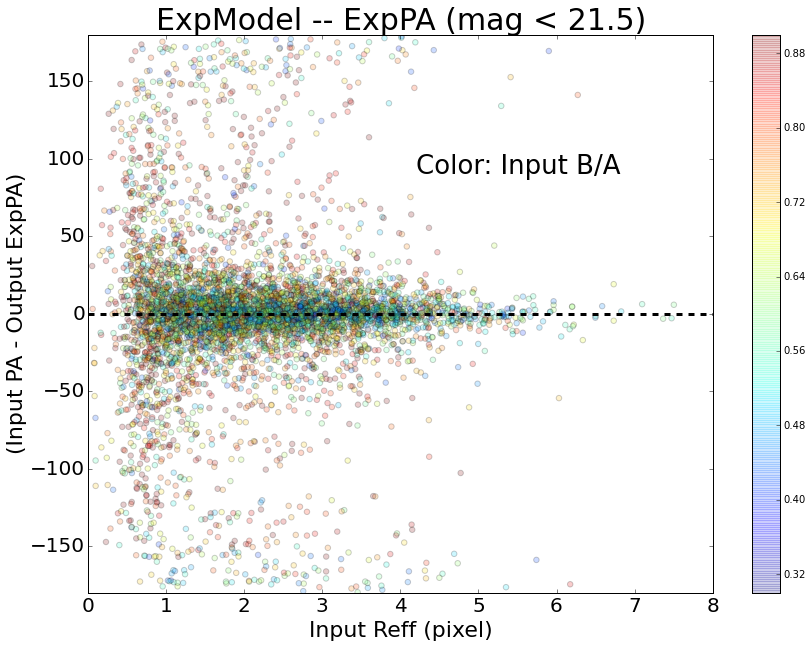

In [28]:
# Scatter plot
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Input Reff (pixel)', fontsize=22)
plt.ylabel('(Input PA - Output ' + paArr + ')', fontsize=22)
plt.title('ExpModel -- ' + paArr + ' (mag < 21.5)', fontsize=30)

plt.scatter(refReff3, difPa3, marker='o', c=refBa3, alpha=0.2, s=30,
            vmin=0.3, vmax=0.9)
plt.scatter(refReff5, difPa5, marker='o', c=refBa5, alpha=0.2, s=30,
            vmin=0.3, vmax=0.9)
plt.axhline(0.0, color='k', linewidth=3, linestyle='--')

plt.xlim((0.00, 8.0))
plt.ylim((-180.0, 180.0))

plt.colorbar()

plt.text(4.20, 90.25, 'Color: Input B/A', fontsize=26)

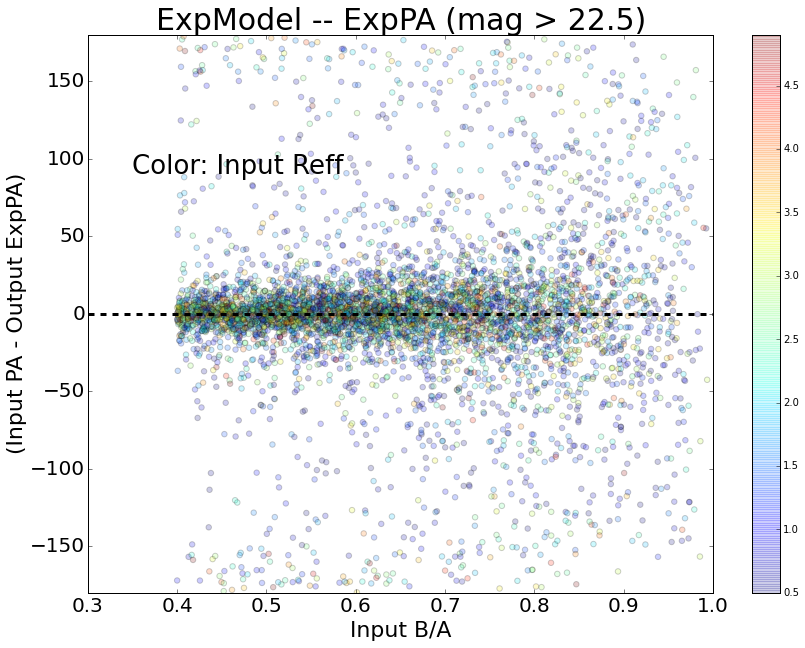

In [29]:
# Scatter plot
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Input B/A', fontsize=22)
plt.ylabel('(Input PA - Output ' + paArr + ')', fontsize=22)
plt.title('ExpModel -- ' + paArr + ' (mag > 22.5)', fontsize=30)

plt.scatter(refBa3, difPa3, marker='o', c=refReff3, alpha=0.2, s=30,
            vmin=0.5, vmax=4.9)
plt.scatter(refBa5, difPa5, marker='o', c=refReff5, alpha=0.2, s=30,
            vmin=0.5, vmax=4.9)
plt.axhline(0.0, color='k', linewidth=3, linestyle='--')

plt.xlim((0.30, 1.0))
plt.ylim((-180.0, 180.0))

plt.colorbar()

plt.text(0.35, 90.25, 'Color: Input Reff', fontsize=26)

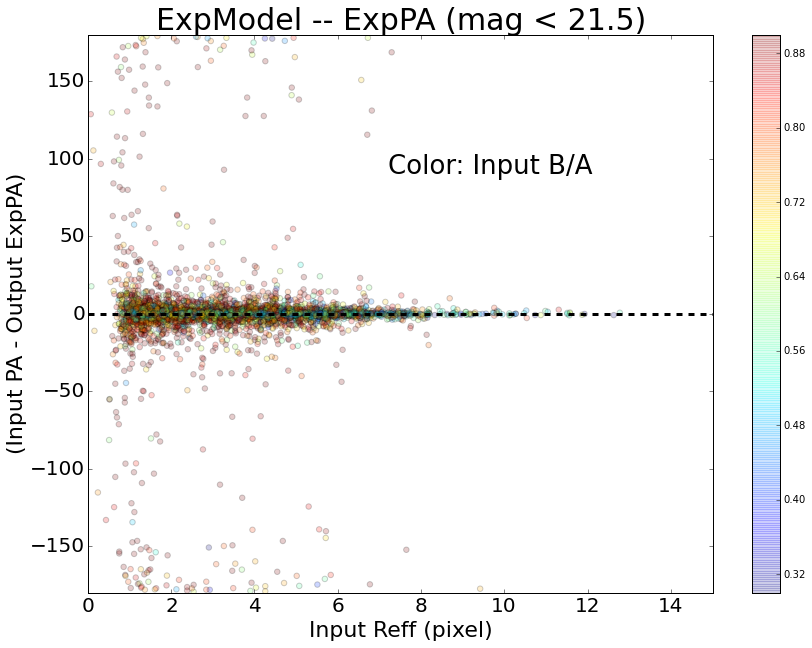

In [30]:
# Scatter plot
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Input Reff (pixel)', fontsize=22)
plt.ylabel('(Input PA - Output ' + paArr + ')', fontsize=22)
plt.title('ExpModel -- ' + paArr + ' (mag < 21.5)', fontsize=30)

plt.scatter(refReff1, difPa1, marker='o', c=refBa1, alpha=0.2, s=30,
            vmin=0.3, vmax=0.9)
plt.scatter(refReff2, difPa2, marker='o', c=refBa2, alpha=0.2, s=30,
            vmin=0.3, vmax=0.9)
plt.scatter(refReff4, difPa4, marker='o', c=refBa4, alpha=0.2, s=30,
            vmin=0.3, vmax=0.9)
plt.axhline(0.0, color='k', linewidth=3, linestyle='--')

plt.xlim((0.00, 15.0))
plt.ylim((-180.0, 180.0))

plt.colorbar()

plt.text(7.20, 90.25, 'Color: Input B/A', fontsize=26)

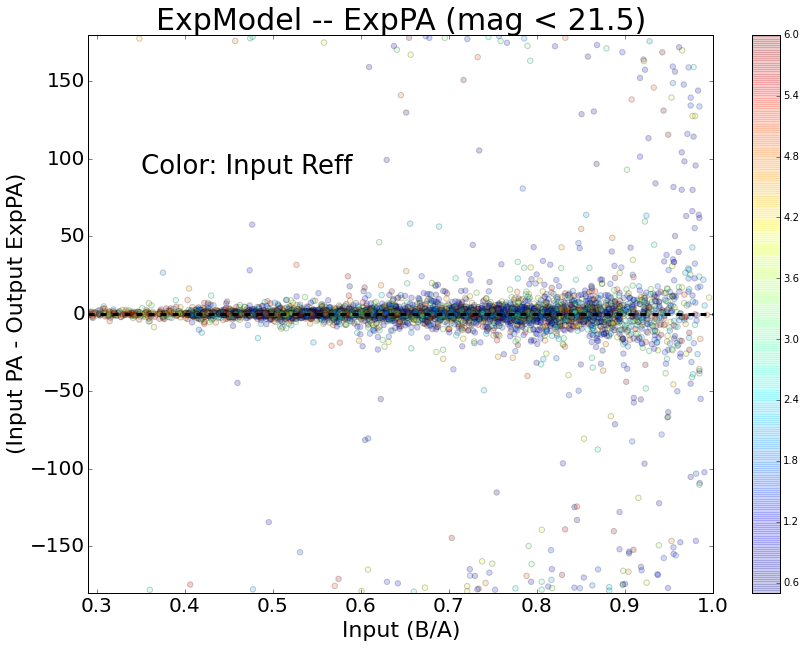

In [32]:
# Scatter plot
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Input (B/A)', fontsize=22)
plt.ylabel('(Input PA - Output ' + paArr + ')', fontsize=22)
plt.title('ExpModel -- ' + paArr + ' (mag < 21.5)', fontsize=30)

plt.scatter(refBa1, difPa1, marker='o', c=refReff1, alpha=0.2, s=30,
            vmin=0.5, vmax=6.0)
plt.scatter(refBa2, difPa2, marker='o', c=refReff2, alpha=0.2, s=30,
            vmin=0.5, vmax=6.0)
plt.scatter(refBa4, difPa4, marker='o', c=refReff4, alpha=0.2, s=30,
            vmin=0.5, vmax=6.0)
plt.axhline(0.0, color='k', linewidth=3, linestyle='--')

plt.xlim((0.29, 1.0))
plt.ylim((-180.0, 180.0))

plt.colorbar()

plt.text(0.35, 90.25, 'Color: Input Reff', fontsize=26)

# Correlations among offsets

In [33]:
# definitions for the axes
left, width    = 0.1, 0.65
right          = left + width 
bottom, height = 0.1, 0.65
bottom_h = bottom + height 
recScat  = [left,   bottom,   width, height]
recHist1 = [right,  bottom,    0.15, height]
recHist2 = [left,   bottom_h, width,   0.15]
recZoom  = [0.13, 0.13, 0.31, 0.31]

(-0.12, 0.12)

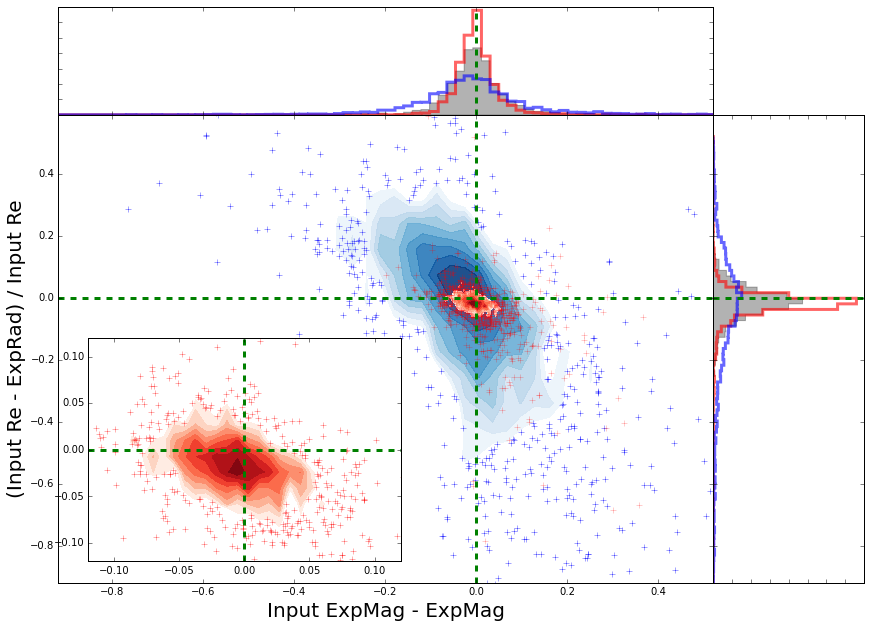

In [34]:
from astroML.plotting import scatter_contour

axScat  = plt.axes(recScat)
axHist1 = plt.axes(recHist1)
axHist2 = plt.axes(recHist2)

# Magnitude and Reff

## Scatter plot and Contour
#axScat.scatter(difMag3, difReff3, marker='o', color='b', alpha=0.1, s=20)
#axScat.scatter(difMag5, difReff5, marker='o', color='b', alpha=0.1, s=20)

scatter_contour(difMag3, difReff3, threshold=5, log_counts=True, ax=axScat,
                histogram2d_args=dict(bins=160),
                plot_args=dict(marker='+', linestyle='none', color='blue', alpha=0.7),
                contour_args=dict(cmap=plt.cm.Blues, alpha=0.9))

scatter_contour(difMag2, difReff2, threshold=4, log_counts=True, ax=axScat,
                histogram2d_args=dict(bins=160),
                plot_args=dict(marker='+', linestyle='none', color='red', alpha=0.4),
                contour_args=dict(cmap=plt.cm.Reds, alpha=1.0))


#axScat.scatter(difMag2, difReff2, marker='o', color='r', alpha=0.1, s=20)
#axScat.scatter(difMag4, difReff4, marker='o', color='r', alpha=0.1, s=20)

#axScat.scatter(difMag1, difReff1, marker='o', color='k', alpha=0.2, s=20)


axScat.set_xlabel('Input ExpMag - ' + magArr, fontsize=20)
axScat.set_ylabel('(Input Re - ' + reffArr + ') / Input Re', fontsize=20)

axScat.axhline(0.0, color='g', linestyle='--', linewidth=3)
axScat.axvline(0.0, color='g', linestyle='--', linewidth=3)

axScat.set_xlim(-0.92, 0.52)
axScat.set_ylim(-0.92, 0.59)

# Histogram 1
n, bins, patches=axHist1.hist(difReff1, bins=80, range=[-0.92, 0.52], 
                             orientation='horizontal', histtype='stepfilled', 
                             color='k', alpha=0.3, normed=1)
n, bins, patches=axHist1.hist(difReff2, bins=80, range=[-0.92, 0.52], 
                             orientation='horizontal', histtype='step', 
                             color='r', alpha=0.6, normed=1, linewidth=3)
n, bins, patches=axHist1.hist(difReff3, bins=80, range=[-0.92, 0.52], 
                             orientation='horizontal', histtype='step', 
                             color='b', alpha=0.6, normed=1, linewidth=3)
axHist1.set_ylim(axScat.get_ylim())
axHist1.axhline(0.0, color='g', linestyle='--', linewidth=3)

axHist1.yaxis.set_major_formatter(NullFormatter())
axHist1.xaxis.set_major_formatter(NullFormatter())

# Histogram 2
n, bins, patches=axHist2.hist(difMag1, bins=80, range=[-0.92, 0.60], 
                             histtype='stepfilled', 
                             color='k', alpha=0.3, normed=1)
n, bins, patches=axHist2.hist(difMag2, bins=80, range=[-0.92, 0.60], 
                             histtype='step', linewidth=3, 
                             color='r', alpha=0.6, normed=1)
n, bins, patches=axHist2.hist(difMag3, bins=80, range=[-0.92, 0.60], 
                             histtype='step', linewidth=3, 
                             color='b', alpha=0.6, normed=1)
axHist2.set_xlim(axScat.get_xlim())
axHist2.axvline(0.0, color='g', linestyle='--', linewidth=3)

axHist2.yaxis.set_major_formatter(NullFormatter())
axHist2.xaxis.set_major_formatter(NullFormatter())

# Zoom-in Window 

axZoom  = plt.axes(recZoom)

scatter_contour(difMag2, difReff2, threshold=5, log_counts=True, ax=axZoom,
                histogram2d_args=dict(bins=100),
                plot_args=dict(marker='+', linestyle='none', color='red', alpha=0.6),
                contour_args=dict(cmap=plt.cm.Reds, alpha=1.0))

axZoom.axhline(0.0, color='g', linestyle='--', linewidth=3)
axZoom.axvline(0.0, color='g', linestyle='--', linewidth=3)

axZoom.set_xlim(-0.12, 0.12)
axZoom.set_ylim(-0.12, 0.12)

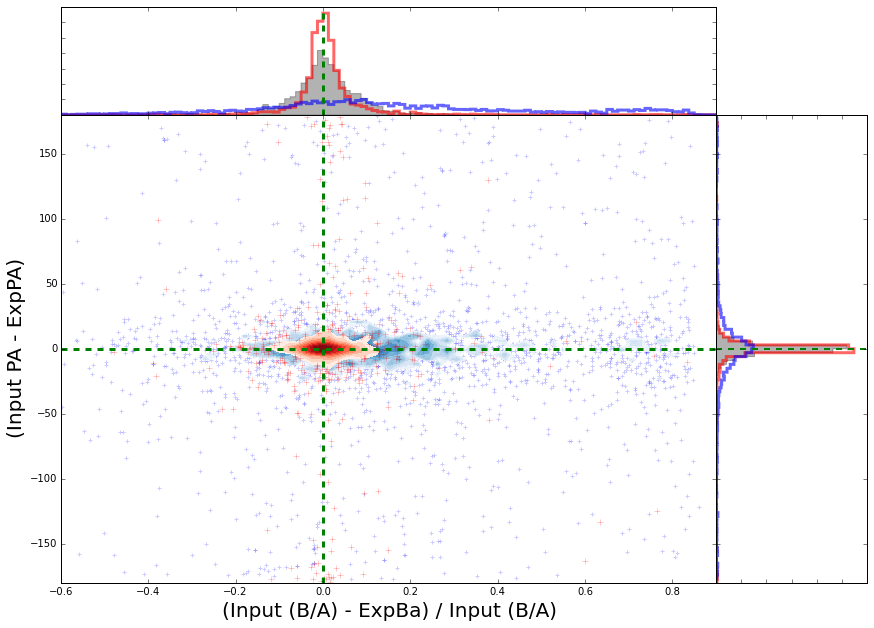

In [35]:
from astroML.plotting import scatter_contour

axScat  = plt.axes(recScat)
axHist1 = plt.axes(recHist1)
axHist2 = plt.axes(recHist2)

# (B/A) and PA

## Scatter plot and Contour
axScat.scatter(difBa3, difPa3, marker='+', color='b', alpha=0.2, s=10)
#axScat.scatter(difBa5, difPa5, marker='o', color='b', alpha=0.1, s=20)

scatter_contour(difBa3, difPa3, threshold=3, log_counts=True, ax=axScat,
                histogram2d_args=dict(bins=100),
                plot_args=dict(marker=',', linestyle='none', color='blue', alpha=0.2),
                contour_args=dict(cmap=plt.cm.Blues, alpha=0.9))

scatter_contour(difBa2, difPa2, threshold=3, log_counts=True, ax=axScat,
                histogram2d_args=dict(bins=100),
                plot_args=dict(marker='+', linestyle='none', color='red', alpha=0.4),
                contour_args=dict(cmap=plt.cm.Reds, alpha=1.0))


#axScat.scatter(difBa2, difPa2, marker='o', color='r', alpha=0.1, s=20)
#axScat.scatter(difBa4, difPa4, marker='o', color='r', alpha=0.1, s=20)

#axScat.scatter(difBa1, difPa1, marker='o', color='k', alpha=0.2, s=20)

axScat.set_xlabel('(Input (B/A) - ' + baArr + ') / Input (B/A)', fontsize=20)
axScat.set_ylabel('(Input PA - ' + paArr + ')', fontsize=20)

axScat.axhline(0.0, color='g', linestyle='--', linewidth=3)
axScat.axvline(0.0, color='g', linestyle='--', linewidth=3)

axScat.set_xlim(-0.6,  0.9)
axScat.set_ylim(-180.0, 180.0)

# Histogram 1
n, bins, patches=axHist1.hist(difPa1, bins=120, range=[-180.0, 180.0], 
                             orientation='horizontal', histtype='stepfilled', 
                             color='k', alpha=0.3, normed=1)
n, bins, patches=axHist1.hist(difPa2, bins=120, range=[-180.0, 180.0], 
                             orientation='horizontal', histtype='step', 
                             color='r', alpha=0.6, normed=1, linewidth=3)
n, bins, patches=axHist1.hist(difPa3, bins=120, range=[-180.0, 180.0], 
                             orientation='horizontal', histtype='step', 
                             color='b', alpha=0.6, normed=1, linewidth=3)
axHist1.set_ylim(axScat.get_ylim())
axHist1.axhline(0.0, color='g', linestyle='--', linewidth=2)

axHist1.yaxis.set_major_formatter(NullFormatter())
axHist1.xaxis.set_major_formatter(NullFormatter())

# Histogram 2
n, bins, patches=axHist2.hist(difBa1, bins=160, range=[-1.0, 1.0], 
                             histtype='stepfilled', 
                             color='k', alpha=0.3, normed=1)
n, bins, patches=axHist2.hist(difBa2, bins=160, range=[-1.0, 1.0], 
                             histtype='step', linewidth=3, 
                             color='r', alpha=0.6, normed=1)
n, bins, patches=axHist2.hist(difBa3, bins=160, range=[-1.0, 1.0], 
                             histtype='step', linewidth=3, 
                             color='b', alpha=0.6, normed=1)
axHist2.set_xlim(axScat.get_xlim())
axHist2.axvline(0.0, color='g', linestyle='--', linewidth=3)

axHist2.yaxis.set_major_formatter(NullFormatter())
axHist2.xaxis.set_major_formatter(NullFormatter())

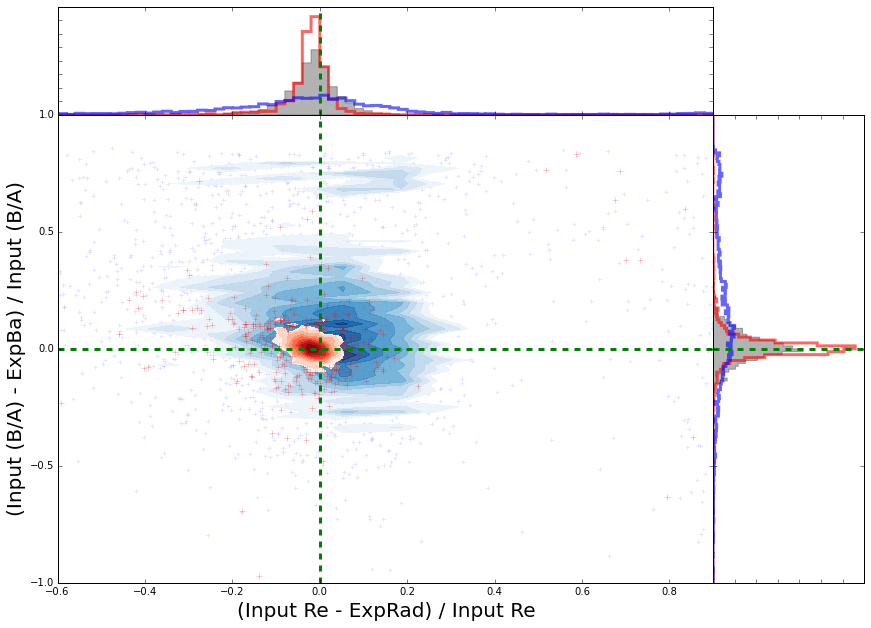

In [36]:
from astroML.plotting import scatter_contour

axScat  = plt.axes(recScat)
axHist1 = plt.axes(recHist1)
axHist2 = plt.axes(recHist2)

# Reff and B/A

## Scatter plot and Contour
axScat.scatter(difReff3, difBa3, marker='+', color='b', alpha=0.1, s=10)
#axScat.scatter(difReff5, difBa5, marker='o', color='b', alpha=0.1, s=20)

scatter_contour(difReff3, difBa3, threshold=5, log_counts=True, ax=axScat,
                histogram2d_args=dict(bins=100),
                plot_args=dict(marker=',', linestyle='none', color='blue', alpha=0.4),
                contour_args=dict(cmap=plt.cm.Blues, alpha=0.9))

scatter_contour(difReff2, difBa2, threshold=3, log_counts=True, ax=axScat,
                histogram2d_args=dict(bins=100),
                plot_args=dict(marker='+', linestyle='none', color='red', alpha=0.4),
                contour_args=dict(cmap=plt.cm.Reds, alpha=1.0))


#axScat.scatter(difReff2, difBa2, marker='o', color='r', alpha=0.1, s=20)
#axScat.scatter(difReff4, difBa4, marker='o', color='r', alpha=0.1, s=20)

#axScat.scatter(difReff1, difBa1, marker='o', color='k', alpha=0.2, s=20)

axScat.set_xlabel('(Input Re - ' + reffArr + ') / Input Re', fontsize=20)
axScat.set_ylabel('(Input (B/A) - ' + baArr + ') / Input (B/A)', fontsize=20)

axScat.axhline(0.0, color='g', linestyle='--', linewidth=3)
axScat.axvline(0.0, color='g', linestyle='--', linewidth=3)

axScat.set_xlim(-0.6,  0.9)
axScat.set_ylim(-1.0,  1.0)

# Histogram 1
n, bins, patches=axHist1.hist(difBa1, bins=160, range=[-1.0, 1.0], 
                             orientation='horizontal', histtype='stepfilled', 
                             color='k', alpha=0.3, normed=1)
n, bins, patches=axHist1.hist(difBa2, bins=160, range=[-1.0, 1.0], 
                             orientation='horizontal', histtype='step', 
                             color='r', alpha=0.6, normed=1, linewidth=3)
n, bins, patches=axHist1.hist(difBa3, bins=160, range=[-1.0, 1.0], 
                             orientation='horizontal', histtype='step', 
                             color='b', alpha=0.6, normed=1, linewidth=3)
axHist1.set_ylim(axScat.get_ylim())
axHist1.axhline(0.0, color='g', linestyle='--', linewidth=3)

axHist1.yaxis.set_major_formatter(NullFormatter())
axHist1.xaxis.set_major_formatter(NullFormatter())

# Histogram 2
n, bins, patches=axHist2.hist(difReff1, bins=100, range=[-1.0, 1.0], 
                             histtype='stepfilled', 
                             color='k', alpha=0.3, normed=1)
n, bins, patches=axHist2.hist(difReff2, bins=100, range=[-1.0, 1.0], 
                             histtype='step', linewidth=3, 
                             color='r', alpha=0.6, normed=1)
n, bins, patches=axHist2.hist(difReff3, bins=100, range=[-1.0, 1.0], 
                             histtype='step', linewidth=3, 
                             color='b', alpha=0.6, normed=1)
axHist2.set_xlim(axScat.get_xlim())
axHist2.axvline(0.0, color='g', linestyle='--', linewidth=3)

axHist2.yaxis.set_major_formatter(NullFormatter())
axHist2.xaxis.set_major_formatter(NullFormatter())

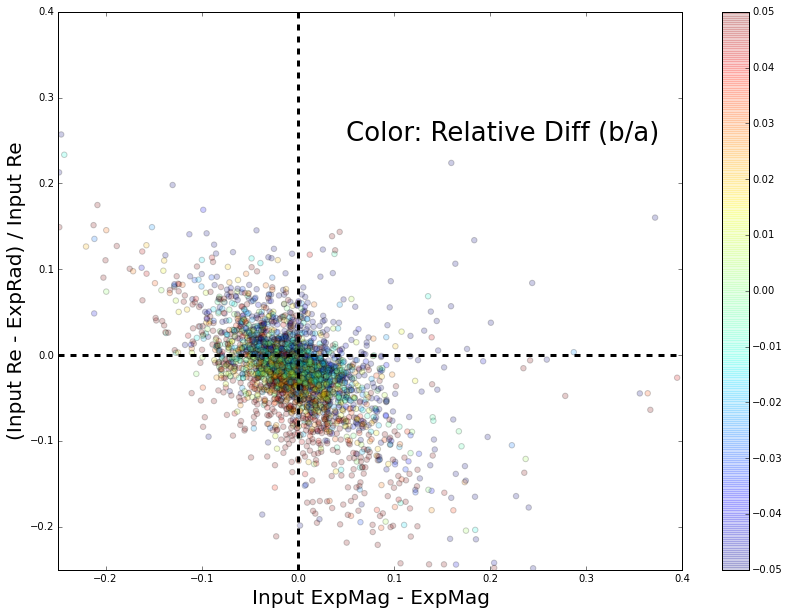

In [35]:
## Scatter plot and Contour
plt.scatter(difMag1, difReff1, marker='o', c=difBa1, alpha=0.2, s=30, 
            vmin=-0.05, vmax=0.05)
plt.scatter(difMag2, difReff2, marker='o', c=difBa2, alpha=0.2, s=30,
            vmin=-0.05, vmax=0.05)

plt.xlabel('Input ExpMag - ' + magArr, fontsize=20)
plt.ylabel('(Input Re - ' + reffArr + ') / Input Re', fontsize=20)

plt.axhline(0.0, color='k', linestyle='--', linewidth=3)
plt.axvline(0.0, color='k', linestyle='--', linewidth=3)

plt.xlim(-0.25, 0.4)
plt.ylim(-0.25, 0.4)

plt.colorbar()

plt.text(0.05, 0.25, 'Color: Relative Diff (b/a)', fontsize=26)

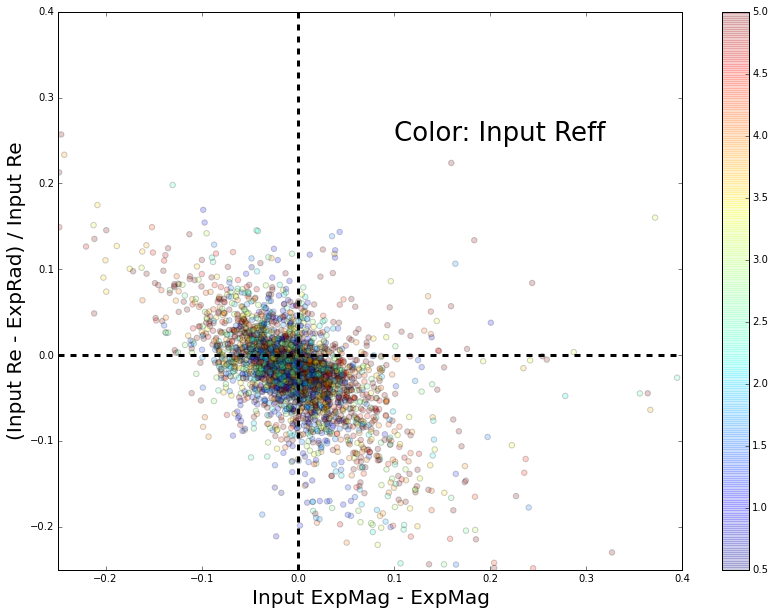

In [51]:
## Scatter plot and Contour
plt.scatter(difMag1, difReff1, marker='o', c=refReff1, alpha=0.2, s=30, 
            vmin=0.5, vmax=5.0)
plt.scatter(difMag2, difReff2, marker='o', c=refReff2, alpha=0.2, s=30,
            vmin=0.5, vmax=5.0)

plt.xlabel('Input ExpMag - ' + magArr, fontsize=20)
plt.ylabel('(Input Re - ' + reffArr + ') / Input Re', fontsize=20)

plt.axhline(0.0, color='k', linestyle='--', linewidth=3)
plt.axvline(0.0, color='k', linestyle='--', linewidth=3)

plt.xlim(-0.25, 0.4)
plt.ylim(-0.25, 0.4)

plt.colorbar()

plt.text(0.10, 0.25, 'Color: Input Reff', fontsize=26)

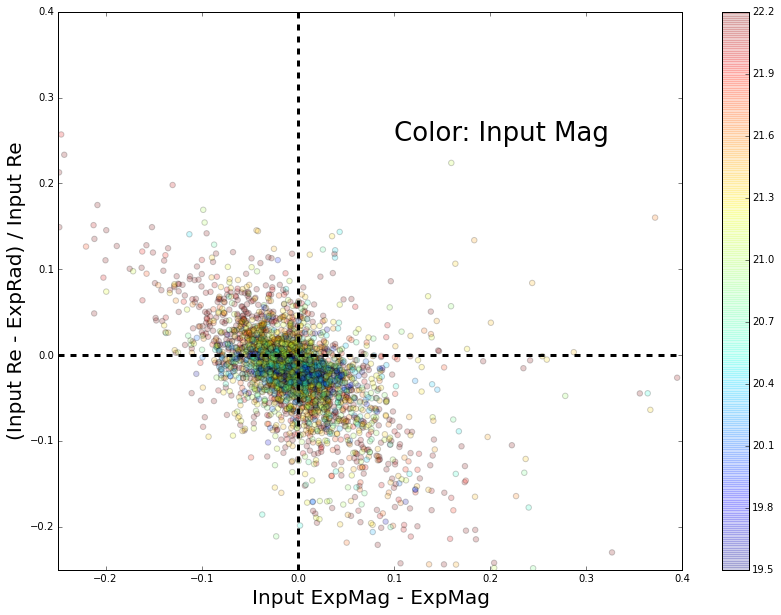

In [55]:
## Scatter plot and Contour
plt.scatter(difMag1, difReff1, marker='o', c=refMag1, alpha=0.2, s=30, 
            vmin=19.5, vmax=22.2)
plt.scatter(difMag2, difReff2, marker='o', c=refMag2, alpha=0.2, s=30,
            vmin=19.5, vmax=22.2)

plt.xlabel('Input ExpMag - ' + magArr, fontsize=20)
plt.ylabel('(Input Re - ' + reffArr + ') / Input Re', fontsize=20)

plt.axhline(0.0, color='k', linestyle='--', linewidth=3)
plt.axvline(0.0, color='k', linestyle='--', linewidth=3)

plt.xlim(-0.25, 0.4)
plt.ylim(-0.25, 0.4)

plt.colorbar()

plt.text(0.10, 0.25, 'Color: Input Mag', fontsize=26)

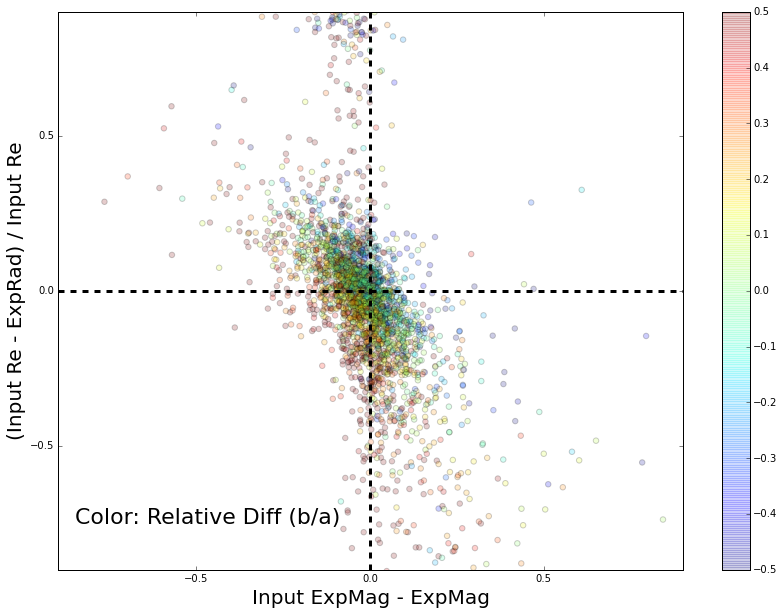

In [41]:
## Scatter plot and Contour
plt.scatter(difMag3, difReff3, marker='o', c=difBa3, alpha=0.2, s=30, 
            vmin=-0.5, vmax=0.5)

plt.xlabel('Input ExpMag - ' + magArr, fontsize=20)
plt.ylabel('(Input Re - ' + reffArr + ') / Input Re', fontsize=20)

plt.axhline(0.0, color='k', linestyle='--', linewidth=3)
plt.axvline(0.0, color='k', linestyle='--', linewidth=3)

plt.xlim(-0.9, 0.9)
plt.ylim(-0.9, 0.9)

plt.colorbar()

plt.text(-0.85, -0.75, 'Color: Relative Diff (b/a)', fontsize=22)

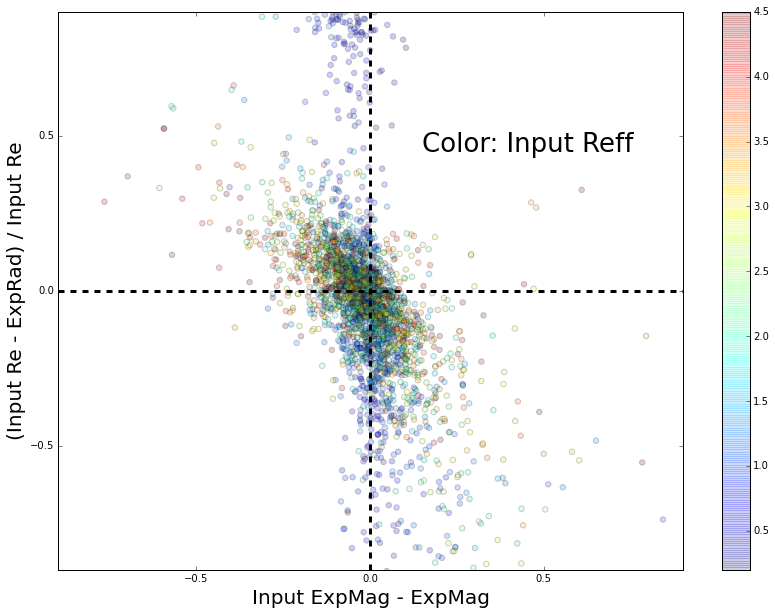

In [54]:
## Scatter plot and Contour
plt.scatter(difMag3, difReff3, marker='o', c=refReff3, alpha=0.2, s=30, 
            vmin=0.2, vmax=4.5)

plt.xlabel('Input ExpMag - ' + magArr, fontsize=20)
plt.ylabel('(Input Re - ' + reffArr + ') / Input Re', fontsize=20)

plt.axhline(0.0, color='k', linestyle='--', linewidth=3)
plt.axvline(0.0, color='k', linestyle='--', linewidth=3)

plt.xlim(-0.9, 0.9)
plt.ylim(-0.9, 0.9)

plt.colorbar()

plt.text(0.15, 0.45, 'Color: Input Reff', fontsize=26)

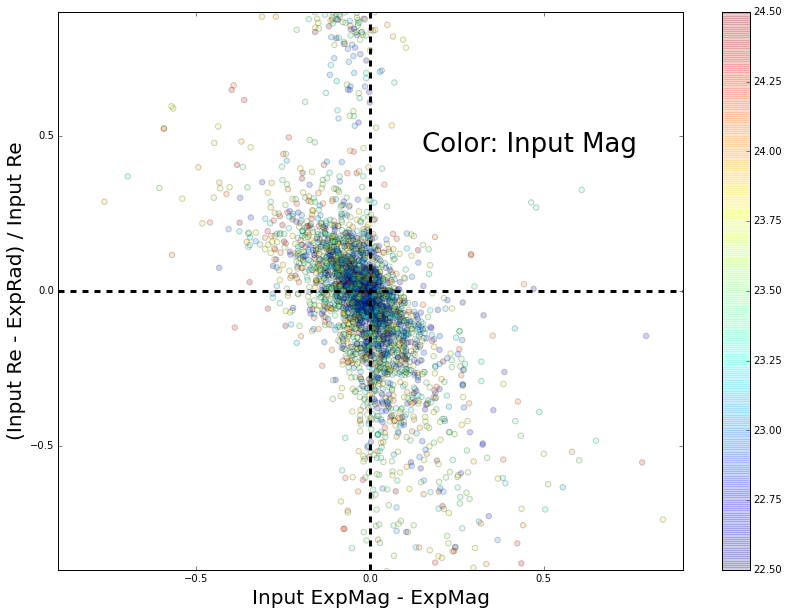

In [56]:
## Scatter plot and Contour
plt.scatter(difMag3, difReff3, marker='o', c=refMag3, alpha=0.2, s=30, 
            vmin=22.5, vmax=24.5)

plt.xlabel('Input ExpMag - ' + magArr, fontsize=20)
plt.ylabel('(Input Re - ' + reffArr + ') / Input Re', fontsize=20)

plt.axhline(0.0, color='k', linestyle='--', linewidth=3)
plt.axvline(0.0, color='k', linestyle='--', linewidth=3)

plt.xlim(-0.9, 0.9)
plt.ylim(-0.9, 0.9)

plt.colorbar()

plt.text(0.15, 0.45, 'Color: Input Mag', fontsize=26)

# fracDev

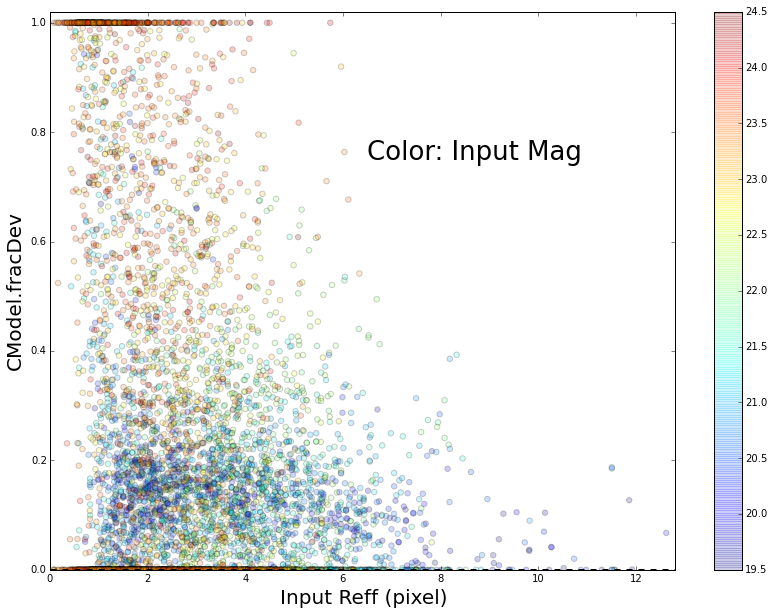

In [22]:
## Scatter plot and Contour
plt.scatter(refReff1, expGood1['cmodel.fracDev'], marker='o', c=refMag1, alpha=0.2, s=30, 
            vmin=19.5, vmax=24.5)
plt.scatter(refReff2, expGood2['cmodel.fracDev'], marker='o', c=refMag2, alpha=0.2, s=30,
            vmin=19.5, vmax=24.5)
plt.scatter(refReff3, expGood3['cmodel.fracDev'], marker='o', c=refMag3, alpha=0.2, s=30,
            vmin=19.5, vmax=24.5)

plt.xlabel('Input Reff (pixel)', fontsize=20)
plt.ylabel('CModel.fracDev', fontsize=20)

plt.axhline(0.0, color='k', linestyle='--', linewidth=3)

plt.xlim(0.0, 12.8)
plt.ylim(0.0, 1.02)

plt.colorbar()

plt.text(6.5, 0.75, 'Color: Input Mag', fontsize=26)

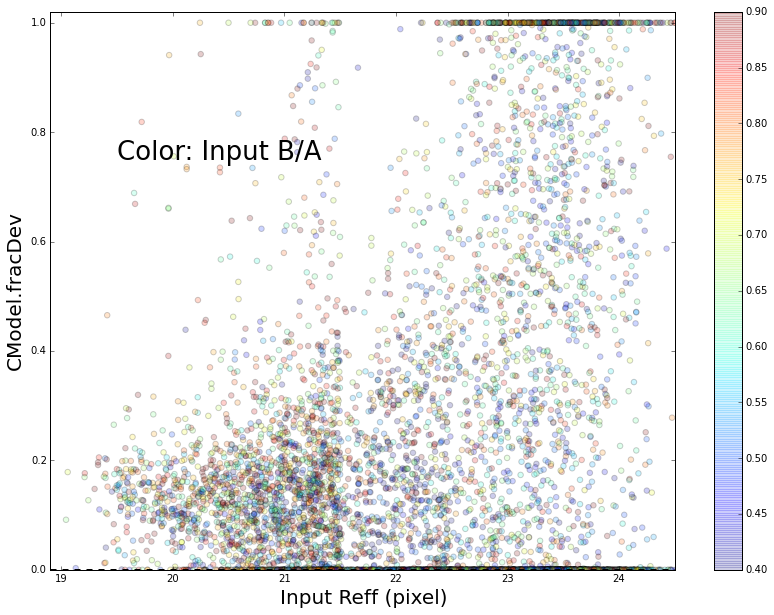

In [26]:
## Scatter plot and Contour
plt.scatter(refMag1, expGood1['cmodel.fracDev'], marker='o', c=refBa1, alpha=0.2, s=30, 
            vmin=0.4, vmax=0.9)
plt.scatter(refMag2, expGood2['cmodel.fracDev'], marker='o', c=refBa2, alpha=0.2, s=30,
            vmin=0.4, vmax=0.9)
plt.scatter(refMag3, expGood3['cmodel.fracDev'], marker='o', c=refBa3, alpha=0.2, s=30,
            vmin=0.4, vmax=0.9)

plt.xlabel('Input Reff (pixel)', fontsize=20)
plt.ylabel('CModel.fracDev', fontsize=20)

plt.axhline(0.0, color='k', linestyle='--', linewidth=3)

plt.xlim(18.9, 24.5)
plt.ylim(0.0, 1.02)

plt.colorbar()

plt.text(19.5, 0.75, 'Color: Input B/A', fontsize=26)

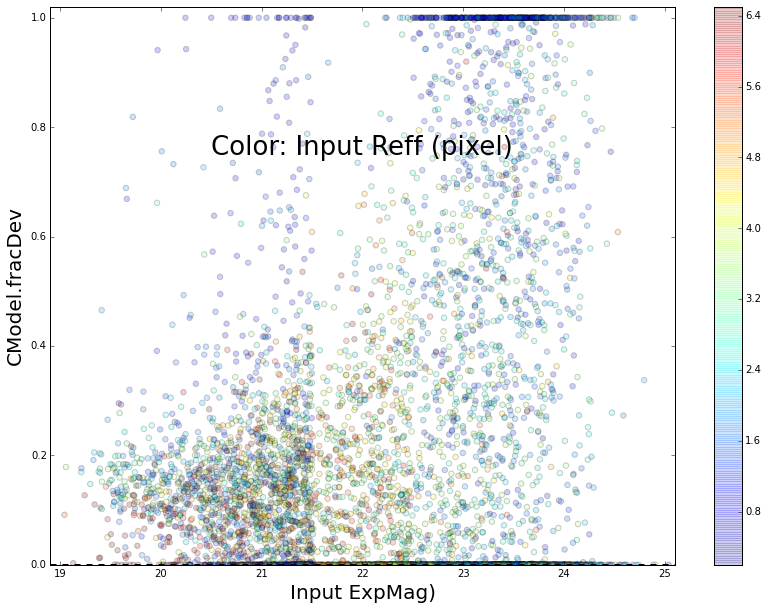

In [44]:
## Scatter plot and Contour
plt.scatter(refMag1, expGood1['cmodel.fracDev'], marker='o', c=refReff1, alpha=0.2, s=30, 
            vmin=0.2, vmax=6.5)
plt.scatter(refMag2, expGood2['cmodel.fracDev'], marker='o', c=refReff2, alpha=0.2, s=30,
            vmin=0.2, vmax=6.5)
plt.scatter(refMag3, expGood3['cmodel.fracDev'], marker='o', c=refReff3, alpha=0.2, s=30,
            vmin=0.2, vmax=6.5)

plt.xlabel('Input ExpMag)', fontsize=20)
plt.ylabel('CModel.fracDev', fontsize=20)

plt.axhline(0.0, color='k', linestyle='--', linewidth=3)

plt.xlim(18.9, 25.1)
plt.ylim(0.0, 1.02)

plt.colorbar()

plt.text(20.5, 0.75, 'Color: Input Reff (pixel)', fontsize=26)